<h1><center> Foursquare Location Matching </center></h1>
<h2><center> Exploratory Data Analysis </center></h2>
<h2><center> Sugata Ghosh </center></h2>

### Contents

- Introduction
- Basic Data Exploration
- Univariate Analysis - Training Set
- Multivariate Analysis - Training Set
- Univariate Analysis - Pairs Set
- Multivariate Analysis - Pairs Set
- Acknowledgements
- References

### Importing libraries

In [1]:
# File system manangement
import time, psutil, os, gc

# Mathematical functions
import math
from math import cos, asin, sqrt, pi

# Data manipulation
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme()
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Others
import operator as op
from functools import reduce, lru_cache

# Suppress or allow warnings
import warnings
warnings.filterwarnings("ignore")

### Runtime and memory usage

In [2]:
# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

# 1. Introduction

- Point of Interest
- The Problem of POI Matching
- About Foursquare
- Data
- Project Objective
- Evaluation Metric

## Point of Interest

A [point of interest](https://en.wikipedia.org/wiki/Point_of_interest) (POI) is a specific point location that someone may find useful or interesting. An example is a point on the Earth representing the location of the Eiffel Tower, or a point on Mars representing the location of its highest mountain, [Olympus Mons](https://en.wikipedia.org/wiki/Olympus_Mons). Most consumers use the term when referring to hotels, campsites, fuel stations or any other categories used in modern automotive navigation systems. Users of a mobile device can be provided with geolocation and time aware POI service that recommends geolocations nearby and with a temporal relevance (e.g. POI to special services in a ski resort are available only in winter). The notion of POI is widely used in cartography, especially in electronic variants including GIS, and GPS navigation software.

## The Problem of POI Matching

It is useful to combine POI data obtained from multiple sources for effective reusability. One issue in merging such data is that different dataset may have variations in POI name, address, and other identifying information for the same POI. It is thus important to identify observations which refer to the same POI. The process of POI matching involves finding POI pairs that refer to the same real-world entity, which is the core issue in geospatial data integration and is perhaps the most technically difficult part of multi-source POI fusion. The raw location data can contain noise, unstructured information, and incomplete or inaccurate attributes, which makes the task even more difficult. Nonetheless, to maintain the highest level of accuracy, the data must be matched and duplicate POIs must be identified and merged with timely updates from multiple sources. A combination of machine-learning algorithms and rigorous human validation methods are optimal for effective de-duplication of such data.

## About Foursquare

[Foursquare Labs Inc.](https://foursquare.com/), commonly known as Foursquare, is an American location technology company and data cloud platform. The company's location platform is the foundation of several business and consumer products, including the [Foursquare City Guide](https://en.wikipedia.org/wiki/Foursquare_City_Guide) and [Foursquare Swarm](https://en.wikipedia.org/wiki/Foursquare_Swarm) apps. Foursquare's products include Pilgrim SDK, Places, Visits, Attribution, Audience, Proximity, and Unfolded Studio. It is one of the leading independent providers of global POI data and is dedicated to building meaningful bridges between digital spaces and physical places. Trusted by leading enterprises like Apple, Microsoft, Samsung, and Uber, Foursquare's tech stack harnesses the power of places and movement to improve customer experiences and drive better business outcomes.

## Data

**Source:** https://www.kaggle.com/competitions/foursquare-location-matching/data

The data considered in the competition comprises over one-and-a-half million place entries for hundreds of thousands of commercial Points-of-Interest (POIs) around the globe. Though the data entries may represent or resemble entries for real places, they may be contaminated with artificial information or additional noise.

The training data comprises eleven attribute fields for over one million place entries, together with:
- `id` : A unique identifier for each entry.
- `point_of_interest` : An identifier for the POI the entry represents. There may be one or many entries describing the same POI. Two entries *match* when they describe a common POI.

In [3]:
# Loading the training data
data_train = pd.read_csv('../input/foursquare-location-matching/train.csv')
print(pd.Series({"Memory usage": "{:.2f} MB".format(data_train.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data_train.shape)}).to_string())
print(" ")
data_train.head()

Memory usage         112.95 MB
Dataset shape    (1138812, 13)
 


id                     name   latitude   longitude  \
0  E_000001272c6c5d     Café Stad Oudenaarde  50.859975    3.634196   
1  E_000002eae2a589           Carioca Manero -22.907225  -43.178244   
2  E_000007f24ebc95         ร้านตัดผมการาเกด  13.780813  100.484900   
3  E_000008a8ba4f48                 Turkcell  37.844510   27.844202   
4  E_00001d92066153  Restaurante Casa Cofiño  43.338196   -4.326821   

                  address        city            state   zip country  url  \
0             Abdijstraat  Nederename  Oost-Vlaanderen  9700      BE  NaN   
1                     NaN         NaN              NaN   NaN      BR  NaN   
2                     NaN         NaN              NaN   NaN      TH  NaN   
3  Adnan Menderes Bulvarı         NaN              NaN   NaN      TR  NaN   
4                     NaN    Caviedes        Cantabria   NaN      ES  NaN   

  phone             categories point_of_interest  
0   NaN                   Bars  P_677e840bb6fc7e  
1   NaN  Brazilian Restaurants  P_d82910d8382a83  
2   NaN   Salons / Barbershops  P_b1066599e78477  
3   NaN     Mobile Phone Shops  P_b2ed86905a4cd3  
4   NaN    Spanish Restaurants  P_809a884d4407fb

In [4]:
# A typical observation from the training set
data_train.iloc[0]

id                       E_000001272c6c5d
name                 Café Stad Oudenaarde
latitude                        50.859975
longitude                        3.634196
address                       Abdijstraat
city                           Nederename
state                     Oost-Vlaanderen
zip                                  9700
country                                BE
url                                   NaN
phone                                 NaN
categories                           Bars
point_of_interest        P_677e840bb6fc7e
Name: 0, dtype: object

The pairs data is a pregenerated set of pairs of place entries from the training data designed to improve detection of matches. It includes:
- `match` : Boolean variables denoting whether or not the pair of entries describes a common POI.

In [5]:
# Loading pregenerated set of pairs of place entries from the training data
data_pairs = pd.read_csv('../input/foursquare-location-matching/pairs.csv')
print(pd.Series({"Memory usage": "{:.2f} MB".format(data_pairs.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data_pairs.shape)}).to_string())
print(" ")
data_pairs.head()

Memory usage        106.55 MB
Dataset shape    (578907, 25)
 


id_1                name_1  latitude_1  longitude_1  \
0  E_000001272c6c5d  Café Stad Oudenaarde   50.859975     3.634196   
1  E_000008a8ba4f48              Turkcell   37.844510    27.844202   
2  E_000023d8f4be44            Island Spa   14.518970   121.018702   
3  E_00007dcd2bb53f     TOGO'S Sandwiches   38.257797  -122.064599   
4  E_0000c362229d93            Coffee Cat    7.082218   125.610244   

                                     address_1      city_1          state_1  \
0                                  Abdijstraat  Nederename  Oost-Vlaanderen   
1                       Adnan Menderes Bulvarı         NaN              NaN   
2  5th Flr, Newport Mall, Resorts World Manila  Pasay City     Metro Manila   
3                     1380 Holiday Ln., Ste. B   Fairfield               CA   
4                                F. Torres St.  Davao City     Davao Region   

   zip_1 country_1                                              url_1  ...  \
0   9700        BE                                                NaN  ...   
1    NaN        TR                                                NaN  ...   
2    NaN        PH                                                NaN  ...   
3  94534        US  https://locations.togos.com/ll/US/CA/Fairfield...  ...   
4   8000        PH                                                NaN  ...   

  longitude_2             address_2      city_2       state_2  zip_2  \
0    3.635206                   NaN         NaN           NaN    NaN   
1   27.845560            batı aydın       aydın           NaN  67500   
2  121.019827                   NaN         NaN           NaN    NaN   
3 -122.064606                   NaN   Fairfield            CA    NaN   
4  125.611457  E. Jacinto Extension  Davao City  Davao Region   8000   

   country_2 url_2 phone_2                        categories_2  match  
0         BE   NaN     NaN                                Bars   True  
1         TR   NaN     NaN                  Electronics Stores  False  
2         PH   NaN     NaN                                Spas   True  
3         US   NaN     NaN                     Sandwich Places   True  
4         PH   NaN     NaN  Coffee Shops, Cafés, Dessert Shops  False  

[5 rows x 25 columns]

In [6]:
# A typical observation from the pregenerated set of pairs
data_pairs.iloc[0]

id_1                E_000001272c6c5d
name_1          Café Stad Oudenaarde
latitude_1                 50.859975
longitude_1                 3.634196
address_1                Abdijstraat
city_1                    Nederename
state_1              Oost-Vlaanderen
zip_1                           9700
country_1                         BE
url_1                            NaN
phone_1                          NaN
categories_1                    Bars
id_2                E_da7fa3963561f8
name_2               Café Oudenaarde
latitude_2                 50.869358
longitude_2                 3.635206
address_2                        NaN
city_2                           NaN
state_2                          NaN
zip_2                            NaN
country_2                         BE
url_2                            NaN
phone_2                          NaN
categories_2                    Bars
match                           True
Name: 0, dtype: object

The test data comprises a set of place entries with their recorded attribute fields, similar to the training set. The POIs in the test data are distinct from the POIs in the training data.

In [7]:
# Loading the test data
data_test = pd.read_csv('../input/foursquare-location-matching/test.csv')
print(pd.Series({"Memory usage": "{:.5f} MB".format(data_test.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data_test.shape)}).to_string())
print(" ")
data_test.head()

Memory usage     0.00058 MB
Dataset shape       (5, 12)
 


id                                      name   latitude  \
0  E_00001118ad0191                   Jamu Petani Bagan Serai   5.012169   
1  E_000020eb6fed40                              Johnny's Bar  40.434209   
2  E_00002f98667edf                                      QIWI  47.215134   
3  E_001b6bad66eb98  Gelora Sriwijaya, Jaka Baring Sport City  -3.014675   
4  E_0283d9f61e569d                  Stadion Gelora Sriwijaya  -3.021727   

    longitude                       address            city          state  \
0  100.535805                           NaN             NaN            NaN   
1  -80.564160                 497 N 12th St         Weirton             WV   
2   39.686088             Межевая улица, 60  Ростов-на-Дону            NaN   
3  104.794374                           NaN             NaN            NaN   
4  104.788628  Jalan Gubernur Hasan Bastari       Palembang  South Sumatra   

       zip country               url         phone       categories  
0      NaN      MY               NaN           NaN            Cafés  
1  26062.0      US               NaN           NaN             Bars  
2      NaN      RU  https://qiwi.com  7.800301e+10             ATMs  
3      NaN      ID               NaN           NaN         Stadiums  
4  11480.0      ID               NaN           NaN  Soccer Stadiums

In [8]:
# A typical observation from the test set
data_test.iloc[0]

id                   E_00001118ad0191
name          Jamu Petani Bagan Serai
latitude                     5.012169
longitude                  100.535805
address                           NaN
city                              NaN
state                             NaN
zip                               NaN
country                            MY
url                               NaN
phone                             NaN
categories                      Cafés
Name: 0, dtype: object

## Project Objective

The goal of the project is to match POIs together. Using the provided dataset of over one-and-a-half million places entries, heavily altered to include noise, duplications, extraneous, or incorrect information, the objective is to produce an algorithm that predicts which place entries represent the same POI. Each place entry in the data includes useful attributes like name, street address, and coordinates. Efficient and successful matching of POIs will make it easier to identify where new stores or businesses would benefit people the most.

## Evaluation Metric

**[Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index).** Also known as *Jaccard similarity coefficient*, it is a statistic used for gauging the similarity and diversity of sample sets. It was developed by [Grove Karl Gilbert](https://en.wikipedia.org/wiki/Grove_Karl_Gilbert) in 1884 as his *ratio of verification (v)* and now is frequently referred to as the *Critical Success Index* in meteorology. It was later developed independently by [Paul Jaccard](https://en.wikipedia.org/wiki/Paul_Jaccard), originally giving the French name *coefficient de communauté* and independently formulated again by T. T. Tanimoto. Thus, the *Tanimoto index* or *Tanimoto coefficient* are also used in some fields. However, they are identical in generally taking the ratio of Intersection over Union. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:

$$ J(A, B) := \frac{\left\vert A \cap B \right\vert}{\left\vert A \cup B \right\vert} = \frac{\left\vert A \cap B \right\vert}{\left\vert A \right\vert + \left\vert B \right\vert - \left\vert A \cap B \right\vert}. $$

Note that by design, $0\leq J\left(A, B\right)\leq 1$. If $A$ and $B$ are both empty, define $J(A, B) = 1$. The Jaccard coefficient is widely used in computer science, ecology, genomics, and other sciences, where binary or binarized data are used. Both the exact solution and approximation methods are available for hypothesis testing with the Jaccard coefficient. See [this paper](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3118-5) ([arxiv version](https://arxiv.org/abs/1903.11372)) for details.

Let us assume that for a specific `id` $a$, our algorithm produces three matches $a$, $b$ and $c$ whereas the true matches are $a$, $b$, $d$ and $e$. Then the Jaccard index for the prediction on this particular `id` will be

$$ \frac{\left\vert \left\{a, b, c\right\} \cap \left\{a, b, d, e\right\} \right\vert}{\left\vert \left\{a, b, c\right\} \cup \left\{a, b, d, e\right\} \right\vert} = \frac{\left\vert \left\{a, b\right\} \right\vert}{\left\vert \left\{a, b, c, d, e\right\} \right\vert} = \frac{2}{5}. $$

Thus, while correct matching predictions are rewarded, incorrect matching predictions are penalised by equal measure. The evaluation metric is simply the mean of Jaccard indices for each of the test observations, i.e. if the test data comprises $n_{\text{test}}$ observations and $J_i$ denotes the Jaccard index corresponding to the $i$th test observation, $i = 1,2,\cdots,n_{\text{test}}$, then the final metric by which a model will be evaluated is:

$$ \frac{1}{n_{\text{test}}} \sum_{i=1}^{n_{\text{test}}} J_i. $$

# 2. Basic Data Exploration

In [9]:
# Shape of the data
print(pd.Series({"Shape of the training set": data_train.shape,
                 "Shape of the pregenerated set of pairs": data_pairs.shape,
                 "Shape of the test set": data_test.shape}).to_string())

Shape of the training set                 (1138812, 13)
Shape of the pregenerated set of pairs     (578907, 25)
Shape of the test set                           (5, 12)


In [10]:
# Count of observations in the data
print(pd.Series({"Number of observations in the training set": len(data_train),
                 "Number of observations in the pregenerated set of pairs": len(data_pairs),
                 "Number of observations in the test set": len(data_test)}).to_string())

Number of observations in the training set                 1138812
Number of observations in the pregenerated set of pairs     578907
Number of observations in the test set                           5


It is evident that the test set, while it does serve as a snapshot of the far larger test data used in the evaluation process of the submitted predictions in [the competition](https://www.kaggle.com/competitions/foursquare-location-matching), has too few observations to do anything with. We shall have to split the training set and use part of it for testing purpose.

In [11]:
# Count of columns in the data
print(pd.Series({"Number of columns in the training set": len(data_train.columns),
                 "Number of columns in the pregenerated set of pairs": len(data_pairs.columns),
                 "Number of columns in the test set": len(data_test.columns)}).to_string())

Number of columns in the training set                 13
Number of columns in the pregenerated set of pairs    25
Number of columns in the test set                     12


In [12]:
# Column names for the training set
data_train.columns.tolist()

['id',
 'name',
 'latitude',
 'longitude',
 'address',
 'city',
 'state',
 'zip',
 'country',
 'url',
 'phone',
 'categories',
 'point_of_interest']

In [13]:
# Column names for the pregenerated set of pairs
data_pairs.columns.tolist()

['id_1',
 'name_1',
 'latitude_1',
 'longitude_1',
 'address_1',
 'city_1',
 'state_1',
 'zip_1',
 'country_1',
 'url_1',
 'phone_1',
 'categories_1',
 'id_2',
 'name_2',
 'latitude_2',
 'longitude_2',
 'address_2',
 'city_2',
 'state_2',
 'zip_2',
 'country_2',
 'url_2',
 'phone_2',
 'categories_2',
 'match']

In [14]:
# Column names for the test set
data_test.columns.tolist()

['id',
 'name',
 'latitude',
 'longitude',
 'address',
 'city',
 'state',
 'zip',
 'country',
 'url',
 'phone',
 'categories']

In [15]:
# Columns in the training set which are not in the test set
[col for col in data_train.columns if col not in data_test.columns]

['point_of_interest']

In [16]:
# Column datatypes for the training set
data_train.dtypes

id                    object
name                  object
latitude             float64
longitude            float64
address               object
city                  object
state                 object
zip                   object
country               object
url                   object
phone                 object
categories            object
point_of_interest     object
dtype: object

In [17]:
# Count of column datatypes for the training set
print(pd.Series({"Number of integer columns": len(data_train.columns[data_train.dtypes == 'int64']),
                 "Number of float columns": len(data_train.columns[data_train.dtypes == 'float64']),
                 "Number of object columns": len(data_train.columns[data_train.dtypes == 'object'])}).to_string())

Number of integer columns     0
Number of float columns       2
Number of object columns     11


In [18]:
# Column datatypes for the pregenerated set of pairs
data_pairs.dtypes

id_1             object
name_1           object
latitude_1      float64
longitude_1     float64
address_1        object
city_1           object
state_1          object
zip_1            object
country_1        object
url_1            object
phone_1          object
categories_1     object
id_2             object
name_2           object
latitude_2      float64
longitude_2     float64
address_2        object
city_2           object
state_2          object
zip_2            object
country_2        object
url_2            object
phone_2          object
categories_2     object
match              bool
dtype: object

In [19]:
# Count of column datatypes for the pregenerated set of pairs
print(pd.Series({"Number of integer columns": len(data_pairs.columns[data_pairs.dtypes == 'int64']),
                 "Number of float columns": len(data_pairs.columns[data_pairs.dtypes == 'float64']),
                 "Number of object columns": len(data_pairs.columns[data_pairs.dtypes == 'object']),
                 "Number of Boolean columns": len(data_pairs.columns[data_pairs.dtypes == 'bool'])}).to_string())

Number of integer columns     0
Number of float columns       4
Number of object columns     20
Number of Boolean columns     1


In [20]:
# Column datatypes for the test set
data_test.dtypes

id             object
name           object
latitude      float64
longitude     float64
address        object
city           object
state          object
zip           float64
country        object
url            object
phone         float64
categories     object
dtype: object

In [21]:
# Count of column datatypes for the test set
print(pd.Series({"Number of integer columns": len(data_test.columns[data_test.dtypes == 'int64']),
                 "Number of float columns": len(data_test.columns[data_test.dtypes == 'float64']),
                 "Number of object columns": len(data_test.columns[data_test.dtypes == 'object'])}).to_string())

Number of integer columns    0
Number of float columns      4
Number of object columns     8


The columns of the test set are exactly the first $12$ columns of the training set, i.e. all columns except `point_of_interest`. The columns of the pairs set are two times replication of these $12$ columns, for two observations, plus the Boolean column `match` which indicates whether or not the two observations refer to the same real-world entity. Note that the columns `zip` and `phone` have object datatype in the training set and `float` datatype in the test set. The underlying reason for this may be the fact that the provided test set has only $5$ observations and hence does not capture the general picture.

In [22]:
# Number of unique values in the training set columns
data_train.nunique()

id                   1138812
name                  842086
latitude             1121701
longitude            1080273
address               558154
city                   68105
state                  17596
zip                    93329
country                  221
url                   171222
phone                 293454
categories             52578
point_of_interest     739972
dtype: int64

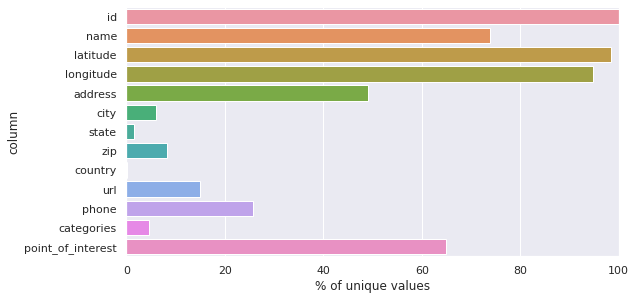

In [23]:
# Number of unique values in the training set columns by percentage
plt.figure(figsize = (9, 13 / 3))
data_temp = (data_train.nunique() / len(data_train)) * 100
s = sns.barplot(x = data_temp.values, y = data_temp.index)
s.set_xlim(0, 100)
# s.bar_label(s.containers[0])
s.set(xlabel = "% of unique values", ylabel = "column")
plt.tight_layout()
plt.show()

In [24]:
# Number of unique values in the columns of the pregenerated set of pairs
data_pairs.nunique()

id_1            464765
name_1          369287
latitude_1      462374
longitude_1     453361
address_1       321612
city_1           46458
state_1          11232
zip_1            70134
country_1          213
url_1           121713
phone_1         193358
categories_1     41403
id_2            565512
name_2          466779
latitude_2      560634
longitude_2     550222
address_2       259112
city_2           46967
state_2          12029
zip_2            57711
country_2          217
url_2            56214
phone_2         105583
categories_2     19561
match                2
dtype: int64

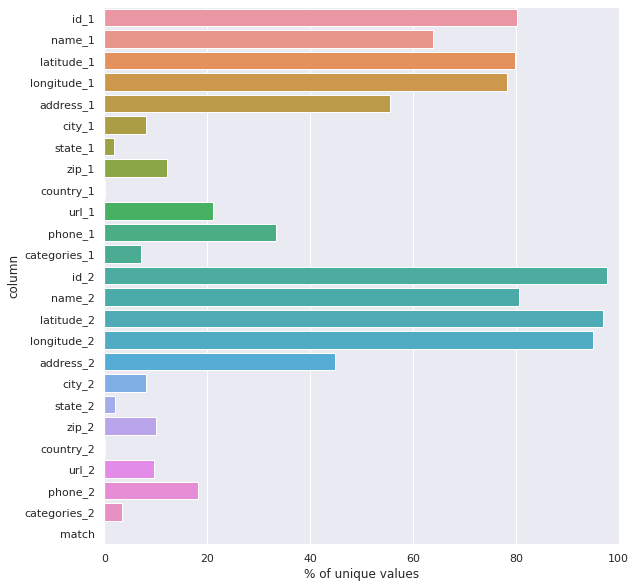

In [25]:
# Number of unique values in the columns of the pregenerated set of pairs by percentage
plt.figure(figsize = (9, 25 / 3))
data_temp = (data_pairs.nunique() / len(data_pairs)) * 100
s = sns.barplot(x = data_temp.values, y = data_temp.index)
s.set_xlim(0, 100)
# s.bar_label(s.containers[0])
s.set(xlabel = "% of unique values", ylabel = "column")
plt.tight_layout()
plt.show()

In [26]:
# Number of unique values in the test set columns
data_test.nunique()

id            5
name          5
latitude      5
longitude     5
address       3
city          3
state         2
zip           2
country       4
url           1
phone         1
categories    5
dtype: int64

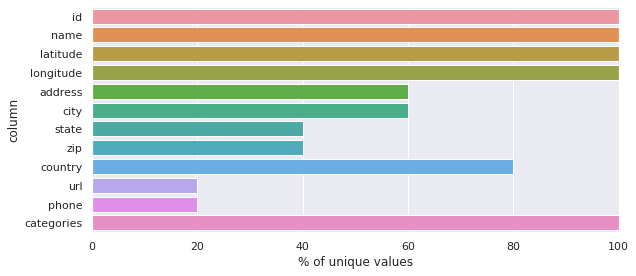

In [27]:
# Number of unique values in the test set columns by percentage
plt.figure(figsize = (9, 4))
data_temp = (data_test.nunique() / len(data_test)) * 100
s = sns.barplot(x = data_temp.values, y = data_temp.index)
s.set_xlim(0, 100)
# s.bar_label(s.containers[0])
s.set(xlabel = "% of unique values", ylabel = "column")
plt.tight_layout()
plt.show()

In [28]:
# Count of duplicate rows
print(pd.Series({"Number of duplicate rows in the training set": data_train.duplicated().sum(),
                 "Number of duplicate rows in the pregenerated set of pairs": data_pairs.duplicated().sum(),
                 "Number of duplicate rows in the test set": data_test.duplicated().sum()}).to_string())

Number of duplicate rows in the training set                 0
Number of duplicate rows in the pregenerated set of pairs    0
Number of duplicate rows in the test set                     0


In [29]:
# Constant columns in the training set
cols_constant_train = data_train.columns[data_train.nunique() == 1].tolist()
if len(cols_constant_train) == 0:
    cols_constant_train = "None"
print(pd.Series({"Constant columns in the training set": cols_constant_train}).to_string())

Constant columns in the training set    None


In [30]:
# Constant columns in the pregenerated set of pairs
cols_constant_pairs = data_pairs.columns[data_pairs.nunique() == 1].tolist()
if len(cols_constant_pairs) == 0:
    cols_constant_pairs = "None"
print(pd.Series({"Constant columns in the pregenerated set of pairs": cols_constant_pairs}).to_string())

Constant columns in the pregenerated set of pairs    None


In [31]:
# Constant columns in the test set
cols_constant_test = data_test.columns[data_test.nunique() == 1].tolist()
if len(cols_constant_test) == 0:
    cols_constant_test = "None"
print(pd.Series({"Constant columns in the test set": cols_constant_test}).to_string())

Constant columns in the test set    [url, phone]


In [32]:
# Count of columns with missing values
print(pd.Series({"Number of columns with missing values in the training set": len(data_train.isna().sum()[data_train.isna().sum() != 0]),
                 "Number of columns with missing values in the pregenerated set of pairs": len(data_pairs.isna().sum()[data_pairs.isna().sum() != 0]),
                 "Number of columns with missing values in the test set": len(data_test.isna().sum()[data_test.isna().sum() != 0])}).to_string())

Number of columns with missing values in the training set                  9
Number of columns with missing values in the pregenerated set of pairs    16
Number of columns with missing values in the test set                      6


In [33]:
# Columns with missing values in the training set with respective proportion of missing values
(data_train.isna().sum()[data_train.isna().sum() != 0]/len(data_train)).sort_values(ascending = False)

url           7.649094e-01
phone         6.989363e-01
zip           5.228484e-01
state         3.693200e-01
address       3.482761e-01
city          2.627203e-01
categories    8.632417e-02
country       9.659189e-06
name          8.781081e-07
dtype: float64

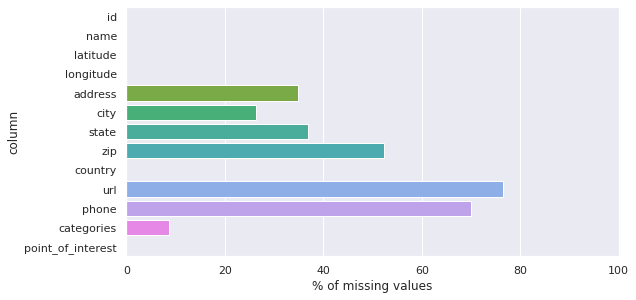

In [34]:
# Missing values in the training set
plt.figure(figsize = (9, 13 / 3))
data_temp = (data_train.isna().sum() * 100 / len(data_train)) #.sort_values()
s = sns.barplot(x = data_temp.values, y = data_temp.index)
s.set_xlim(0, 100)
# s.bar_label(s.containers[0])
s.set(xlabel = "% of missing values", ylabel = "column")
plt.tight_layout()
plt.show()

Three columns `zip`, `phone` and `url` have over $50\%$ values missing, while two more columns `address` and `state` have over $30\%$ values missing.

In [35]:
# Columns with missing values in the pregenerated set of pairs with respective proportion of missing values
(data_pairs.isna().sum()[data_pairs.isna().sum() != 0]/len(data_pairs)).sort_values(ascending = False)

url_2           0.853431
phone_2         0.794504
zip_2           0.611635
url_1           0.599580
phone_1         0.533566
state_2         0.465045
address_2       0.460195
zip_1           0.378987
city_2          0.365200
state_1         0.218672
address_1       0.178827
categories_2    0.131240
city_1          0.113972
categories_1    0.028146
country_1       0.000014
country_2       0.000010
dtype: float64

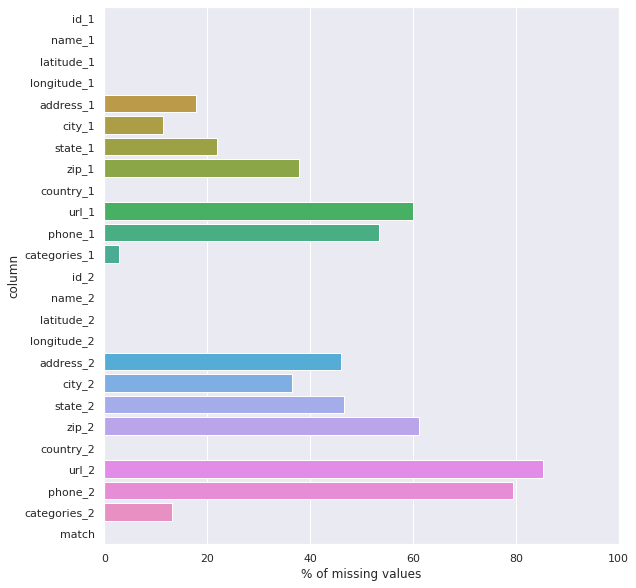

In [36]:
# Missing values in the pregenerated set of pairs
plt.figure(figsize = (9, 25 / 3))
data_pairs_missing = (data_pairs.isna().sum() * 100 / len(data_pairs)) #.sort_values()
s = sns.barplot(x = data_pairs_missing.values, y = data_pairs_missing.index)
s.set_xlim(0, 100)
# s.bar_label(s.containers[0])
s.set(xlabel = "% of missing values", ylabel = "column")
plt.tight_layout()
plt.show()

In [37]:
# Columns with missing values in the test set with respective proportion of missing values
(data_test.isna().sum()[data_test.isna().sum() != 0]/len(data_test)).sort_values(ascending = False)

url        0.8
phone      0.8
state      0.6
zip        0.6
address    0.4
city       0.4
dtype: float64

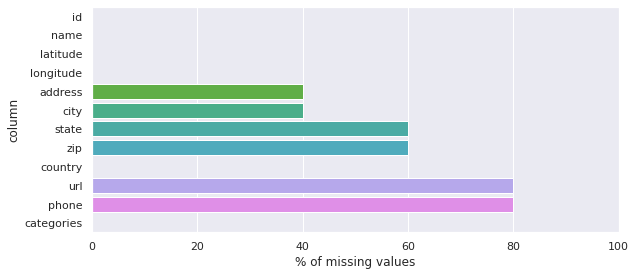

In [38]:
# Missing values in the test set
plt.figure(figsize = (9, 4))
data_test_missing = (data_test.isna().sum() * 100 / len(data_test)) #.sort_values()
s = sns.barplot(x = data_test_missing.values, y = data_test_missing.index)
s.set_xlim(0, 100)
# s.bar_label(s.containers[0])
s.set(xlabel = "% of missing values", ylabel = "column")
plt.tight_layout()
plt.show()

In [39]:
# Statistical description of numerical variables in the training set
data_train.describe()

latitude     longitude
count  1.138812e+06  1.138812e+06
mean   2.687460e+01  2.070497e+01
std    2.314474e+01  8.267784e+01
min   -8.492774e+01 -1.751602e+02
25%    1.276506e+01 -7.143512e+01
50%    3.570244e+01  2.893202e+01
75%    4.167972e+01  1.022178e+02
max    8.505113e+01  1.784404e+02

In [40]:
# Statistical description of categorical variables in the training set
data_train.describe(include = ['O'])

id       name     address       city   state     zip  \
count            1138812    1138811      742191     839623  718226  543386   
unique           1138812     842086      558154      68105   17596   93329   
top     E_000001272c6c5d  Starbucks  Terminal 1  Singapore      CA    9000   
freq                   1       5637         261      10259   28863    1885   

        country                    url       phone  \
count   1138801                 267724      342855   
unique      221                 171222      293454   
top          US  https://www.sej.co.jp  8667332693   
freq     245284                    921        1875   

                                         categories point_of_interest  
count                                       1040505           1138812  
unique                                        52578            739972  
top     Residential Buildings (Apartments / Condos)  P_fb339198a31db3  
freq                                          25481               332

In [41]:
# Statistical description of numerical variables in the pregenerated set of pairs
data_pairs.describe()

latitude_1    longitude_1     latitude_2    longitude_2
count  578907.000000  578907.000000  578907.000000  578907.000000
mean       26.104358      24.759940      26.092840      24.785947
std        23.210853      82.244791      23.213278      82.250231
min       -80.857570    -175.141634     -84.927740    -175.160248
25%         6.032218     -61.467652       5.987273     -61.462669
50%        35.623278      30.214258      35.618854      30.220696
75%        41.290456     103.844485      41.285191     103.845012
max        84.928321     178.437698      85.051128     178.440386

In [42]:
# Statistical description of categorical variables in the pregenerated set of pairs
data_pairs.describe(include = ['O'])

id_1     name_1           address_1  city_1 state_1  \
count             578907     578907              475383  512928  452316   
unique            464765     369287              321612   46458   11232   
top     E_74ba66c8496334  Starbucks  Jalan Raya Bandara  Москва      CA   
freq                 348       3871                 350    8143   14285   

         zip_1 country_1                     url_1     phone_1  \
count   359509    578899                    231806      270022   
unique   70134       213                    121713      193358   
top       9000        US  http://www.7eleven.co.th  8667332693   
freq      1315    117793                       782        1153   

          categories_1              id_2     name_2 address_2     city_2  \
count           562613            578907     578907    312497     367490   
unique           41403            565512     466779    259112      46967   
top     Shopping Malls  E_59223061bee71c  Starbucks        日本  Singapore   
freq             11606                23       2734       172       5222   

       state_2   zip_2 country_2                  url_2       phone_2  \
count   309689  224827    578901                  84850        118963   
unique   12029   57711       217                  56214        105583   
top         CA    9000        US  http://www.redbox.com  +18667332693   
freq     13525     731    117779                    557           690   

                                       categories_2  
count                                        502931  
unique                                        19561  
top     Residential Buildings (Apartments / Condos)  
freq                                          11604

In [43]:
# Statistical description of numerical variables in the test set
data_test.describe()

latitude   longitude           zip         phone
count   5.000000    5.000000      2.000000  1.000000e+00
mean   17.325022   53.848147  18771.000000  7.800301e+10
std    24.529335   80.058448  10311.031083           NaN
min    -3.021727  -80.564160  11480.000000  7.800301e+10
25%    -3.014675   39.686088  15125.500000  7.800301e+10
50%     5.012169  100.535805  18771.000000  7.800301e+10
75%    40.434209  104.788628  22416.500000  7.800301e+10
max    47.215134  104.794374  26062.000000  7.800301e+10

In [44]:
# Statistical description of categorical variables in the test set
data_test.describe(include = ['O'])

id                     name        address     city  \
count                  5                        5              3        3   
unique                 5                        5              3        3   
top     E_00001118ad0191  Jamu Petani Bagan Serai  497 N 12th St  Weirton   
freq                   1                        1              1        1   

       state country               url categories  
count      2       5                 1          5  
unique     2       4                 1          5  
top       WV      ID  https://qiwi.com      Cafés  
freq       1       2                 1          1

**Training set synopsis:**

- Number of observations: $1138812$
- Number of columns: $13$
- Number of integer columns: $0$
- Number of float columns: $2$
- Number of object columns: $11$
- Number of duplicate observations: $0$
- Constant columns: None
- Number of columns with missing values: $9$
- Memory Usage: $112.95$ MB

**Pregenerated set of pairs synopsis:**

- Number of observations: $578907$
- Number of columns: $25$
- Number of integer columns: $2$
- Number of float columns: $30$
- Number of object columns: $1$
- Number of duplicate observations: $0$
- Constant columns: None
- Number of columns with missing values: $16$
- Memory Usage: $106.55$ MB

**Test set synopsis:**

- Number of observations: $5$
- Number of columns: $12$
- Number of integer columns: $0$
- Number of float columns: $4$
- Number of object columns: $8$
- Number of duplicate observations: $0$
- Constant columns: `url`, `phone`
- Number of columns with missing values: $6$
- Memory Usage: $0.00058$ MB

# 3. Univariate Analysis - Training Set

- Point of Interest
- Latitude and Longitude
- Country
- State
- City
- Categories
- Name
- Address
- Phone
- URL

## Point of Interest

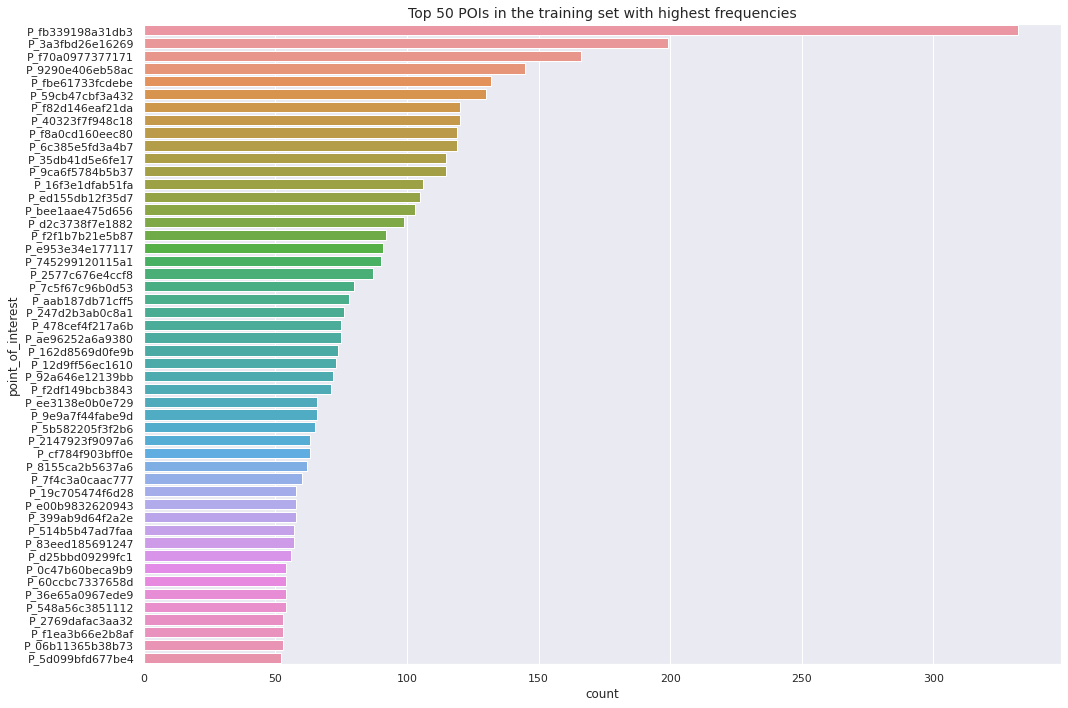

In [45]:
# Horizontal countplot of state of training observations located in the United States of America
cutoff = min(len(data_train['point_of_interest'].value_counts()), 50)
order_descending = data_train.groupby('point_of_interest').size().sort_values().index[::-1][: cutoff].tolist()
plt.figure(figsize = (15, cutoff / 5))
sns.countplot(data = data_train, y = 'point_of_interest', order = order_descending)
plt.title(f"Top {cutoff} POIs in the training set with highest frequencies", fontsize = 14)
plt.tight_layout()
plt.show()

We observe a big number of POI matching, with `P_fb339198a31db3` appearing as many as $332$ times.

## Latitude and Longitude

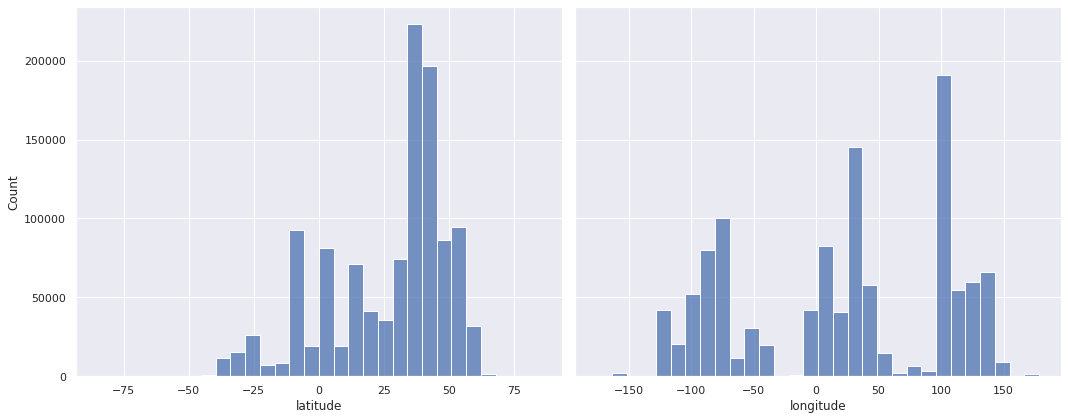

In [46]:
# Histograms of latitude and longitude of observations in the training set
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharey = True)
sns.histplot(data = data_train, x = 'latitude', bins = 30, ax = ax[0])
sns.histplot(data = data_train, x = 'longitude', bins = 30, ax = ax[1])
ax[1].set_ylabel(" ")
plt.tight_layout()
plt.show()

We observe that a big chunk of observations fall inside the latitude interval $30$ to $60$, which covers much of `United States of America` as well as many countries from `Europe`. There are not many observations below $-50$ and above $70$ as these point to the two polar regions and their surrounding areas, which expectedly do not contain many POIs.

As for the longitude, we can see three separate groups. The first group is from $-125$ to $-25$, which covers `North America` and `South America`. The second group is from $-25$ to $75$, which covers `Europe` and `Africa`. The third and final group is from $75$ to $175$, which covers `Asia` and `Australia`. There four region of troughs in the histogram of longitudes. The first and the forth troughs (in the extreme left and the extreme right, which are joined because Earth is round) are due to the Pacific ocean, the second trough is due to the Atlantic ocean, where as the third trough is due to the Indian ocean, as well as lack of observations from some parts of `Russia` and the west part of `China`. A scatterplot of latitude and longitude, which is given in the next section, provides a clearer picture of the distribution of location of the training observations.

Next, we present horizontal countplots of the object-type columns. We begin by presenting the top countries with most training observations. For labelling purpose, we use a .json file which contains the [ISO 3166-1 alpha-2](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2) codes for $246$ countries or territories.

## Country

In [47]:
# ISO 3166-1 alpha-2 country codes
url_iso_alpha_2 = "https://raw.githubusercontent.com/sugatagh/Foursquare-Location-Matching/main/JSON/ISO_3166-1_alpha-2.json"
dict_iso_alpha_2 = pd.read_json(url_iso_alpha_2, typ = 'series')

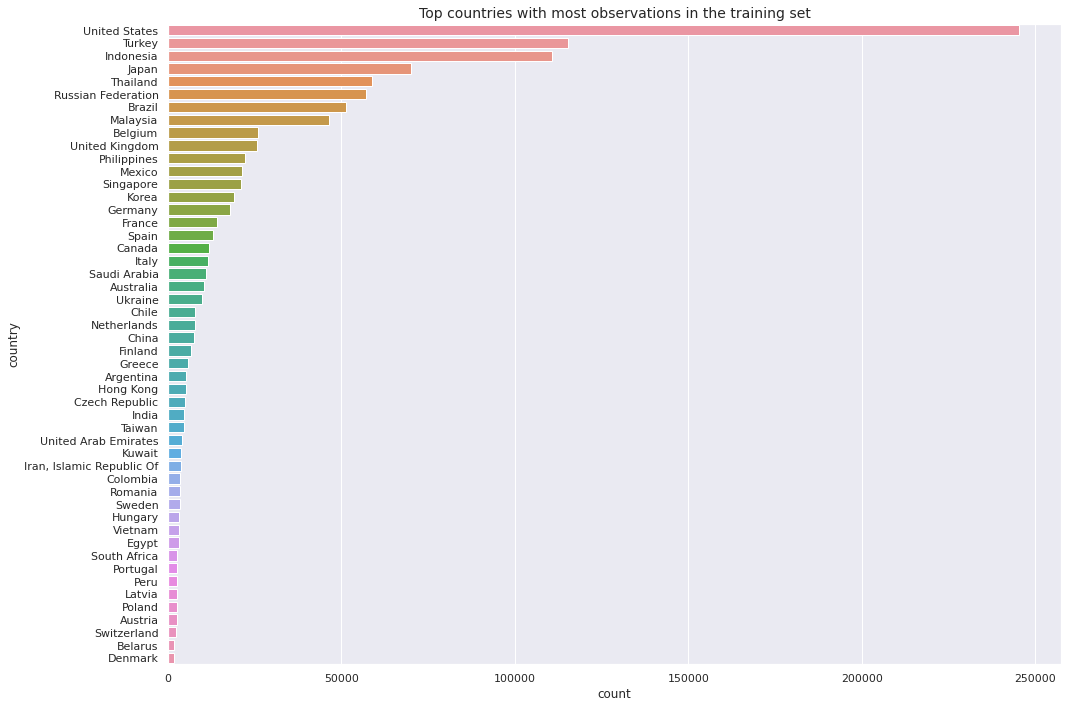

In [48]:
# Horizontal countplot of country of observations in the training set
data_train_country = pd.DataFrame()
data_train_country['country'] = data_train['country'].map(dict_iso_alpha_2)
cutoff = min(len(data_train_country['country'].value_counts()), 50)
order_descending = data_train_country.groupby('country').size().sort_values().index[::-1][: cutoff].tolist()
plt.figure(figsize = (15, cutoff / 5))
sns.countplot(data = data_train_country, y = 'country', order = order_descending)
plt.title("Top countries with most observations in the training set", fontsize = 14)
plt.tight_layout()
plt.show()

We observe that `United States` has the highest number of training observations by a large margin, followed by `Turkey` and `Indonesia`.

## State

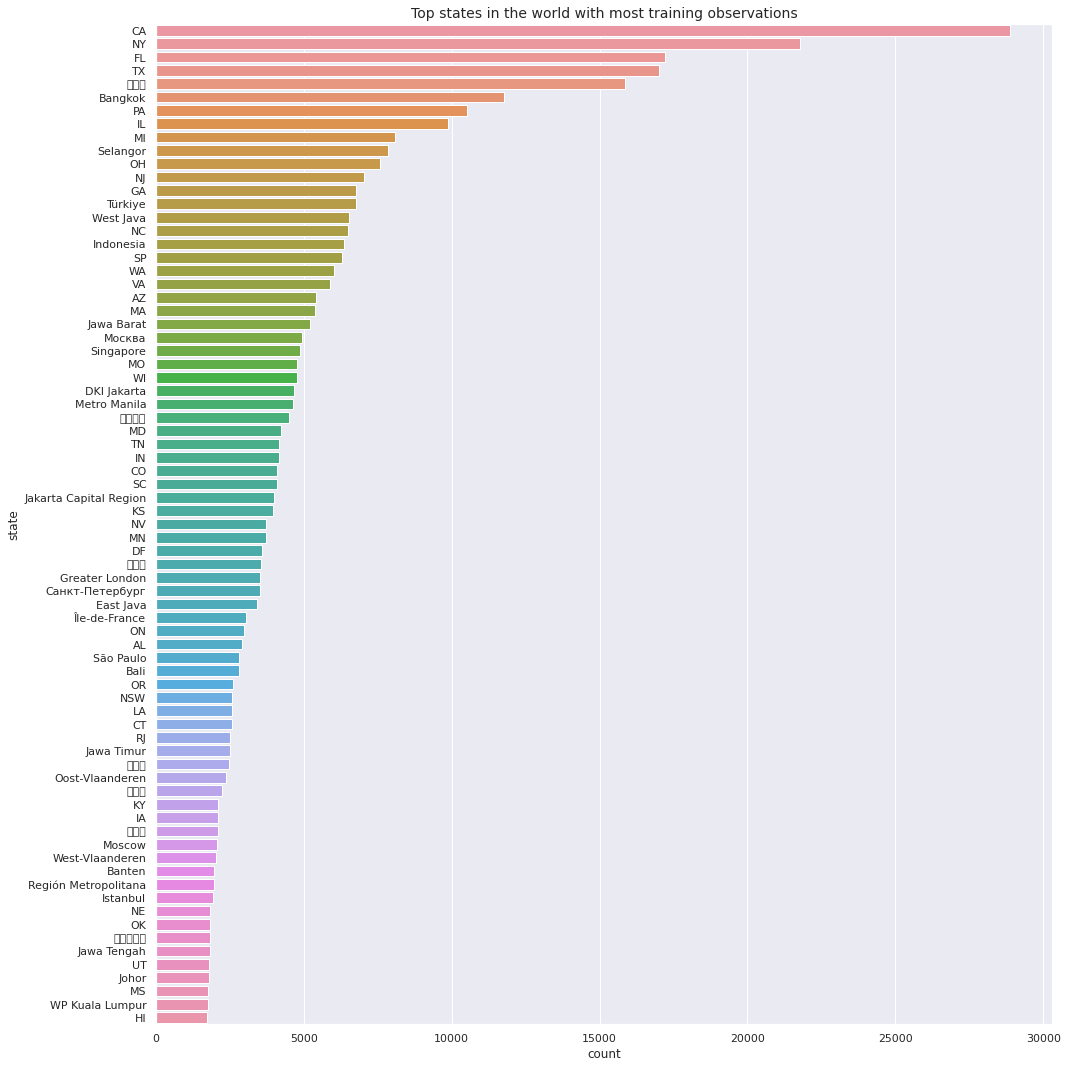

In [49]:
# Horizontal countplot of state of training observations
cutoff = min(len(data_train['state'].value_counts()), 75)
order_descending = data_train.groupby('state').size().sort_values().index[::-1][: cutoff].tolist()
fig, ax = plt.subplots(1, 1, figsize = (15, cutoff / 5), sharex = True)
sns.countplot(data = data_train, y = 'state', order = order_descending, ax = ax)
ax.set_title("Top states in the world with most training observations", fontsize = 14)
plt.tight_layout()
plt.show()

The state of California (`CA`) comes out on top, followed by New York (`NY`) and Florida (`FL`). Often same state is reported in different names, caused by the variation in full name, short name, [postal abbreviations](https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations), as well as uppercase and lowercase. For example, `CA`, `Calif`, `California`, `Ca` or `NY`, `New York`, `Ny`, `ny` or `Texas`, `Tx`, `tx`. It may be useful to match the state names with the respective postal abbreviations using a dictionary or otherwise. Also, to get rid of the variation due to capitalization of letters in general, we may convert all the reported object values (not just for the `state` column) to lowercase.

## City

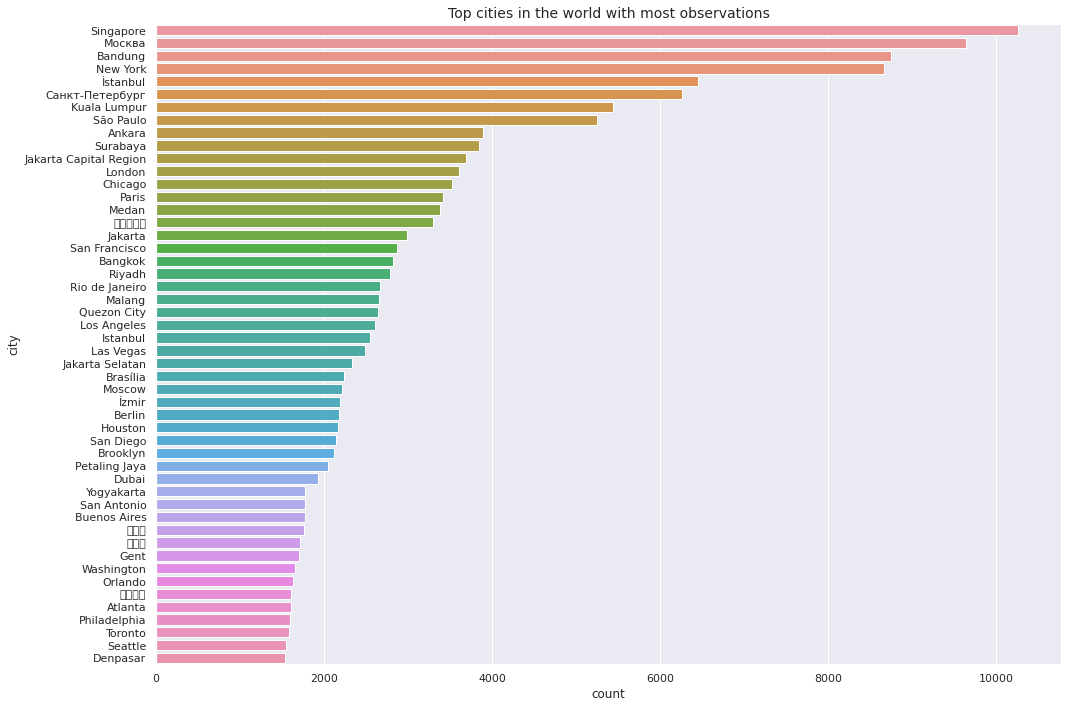

In [50]:
# Horizontal countplot of city of training observations
cutoff = min(len(data_train['city'].value_counts()), 50)
order_descending = data_train.groupby('city').size().sort_values().index[::-1][: cutoff].tolist()
fig, ax = plt.subplots(1, 1, figsize = (15, cutoff / 5), sharex = True)
sns.countplot(data = data_train, y = 'city', order = order_descending, ax = ax)
ax.set_title("Top cities in the world with most observations", fontsize = 14)
plt.tight_layout()
plt.show()

`Singapore` has most training observations, followed closely by `Mockba` and `Bandung`.

## ZIP Code

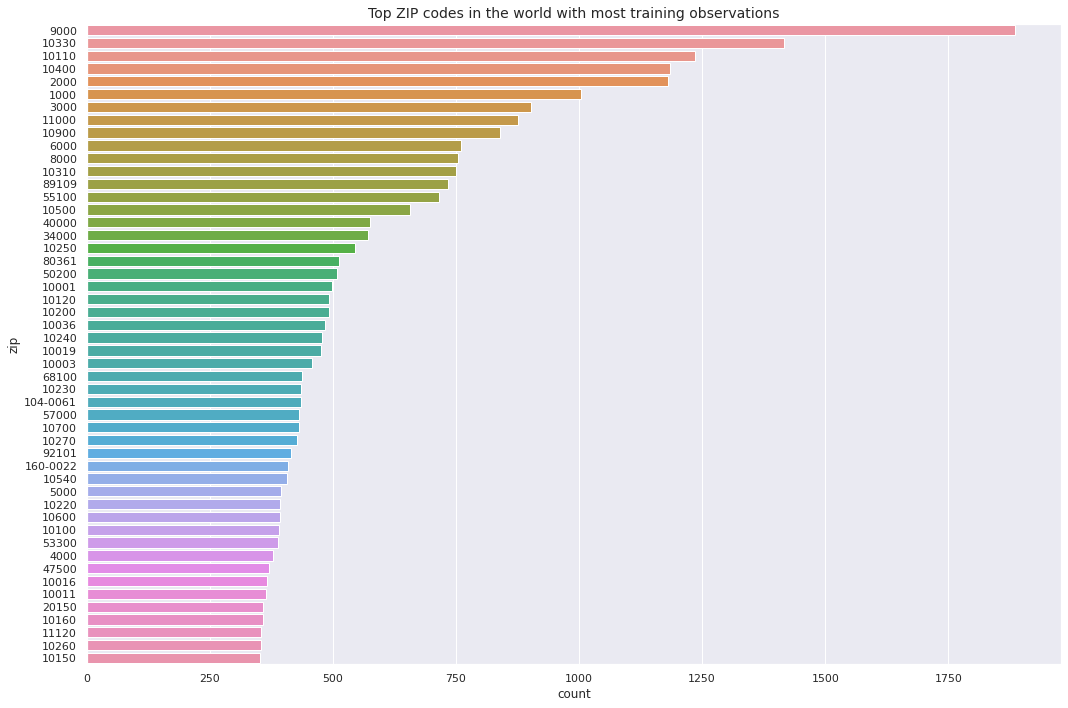

In [51]:
# Horizontal countplot of ZIP code of training observations
cutoff = min(len(data_train['zip'].value_counts()), 50)
order_descending = data_train.groupby('zip').size().sort_values().index[::-1][: cutoff].tolist()
fig, ax = plt.subplots(1, 1, figsize = (15, cutoff / 5), sharex = True)
sns.countplot(data = data_train, y = 'zip', order = order_descending, ax = ax)
ax.set_title("Top ZIP codes in the world with most training observations", fontsize = 14)
plt.tight_layout()
plt.show()

We observe that the ZIP code with highest number of training observations is `9000`, followed by `10330` and `10110`. Note that postal/zip codes may not be unique globally. So the plot in the right side can be misleading.

## Categories

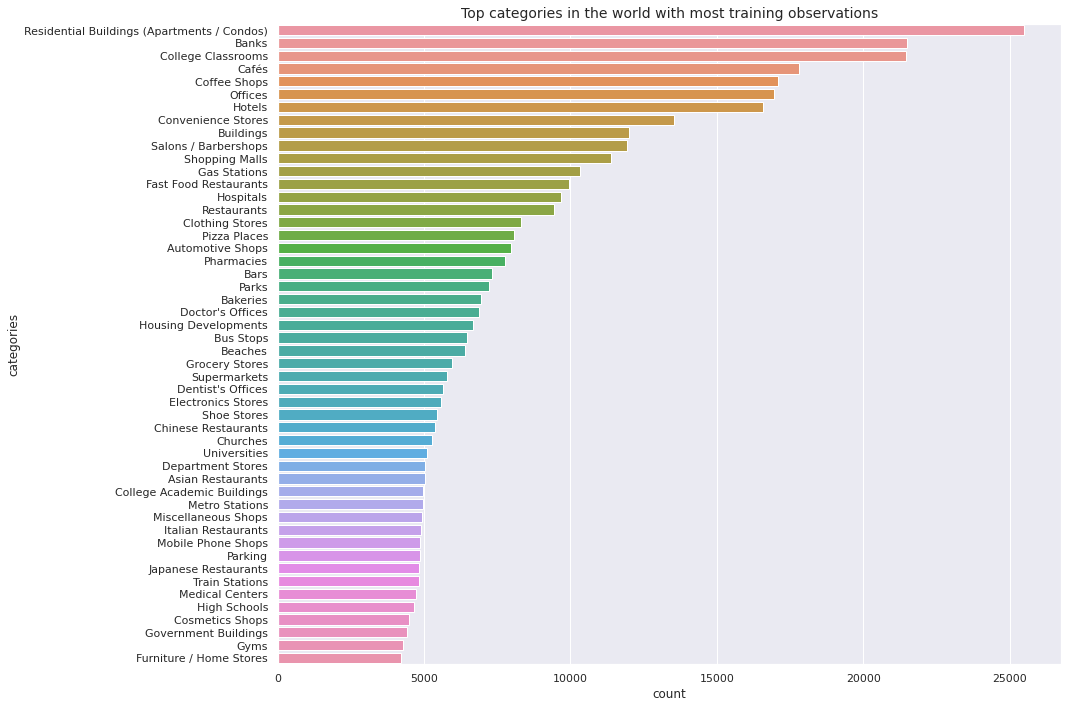

In [52]:
# Horizontal countplot of categories of training observations in the world
cutoff = min(len(data_train['categories'].value_counts()), 50)
order_descending = data_train.groupby('categories').size().sort_values().index[::-1][: cutoff].tolist()
plt.figure(figsize = (15, cutoff / 5))
sns.countplot(data = data_train, y = 'categories', order = order_descending)
plt.title("Top categories in the world with most training observations", fontsize = 14)
plt.tight_layout()
plt.show()

`Residential Buildings (Apartments / Condos)` has the highest number of training observations, followed by `Banks` and `College classrooms`.

## Name

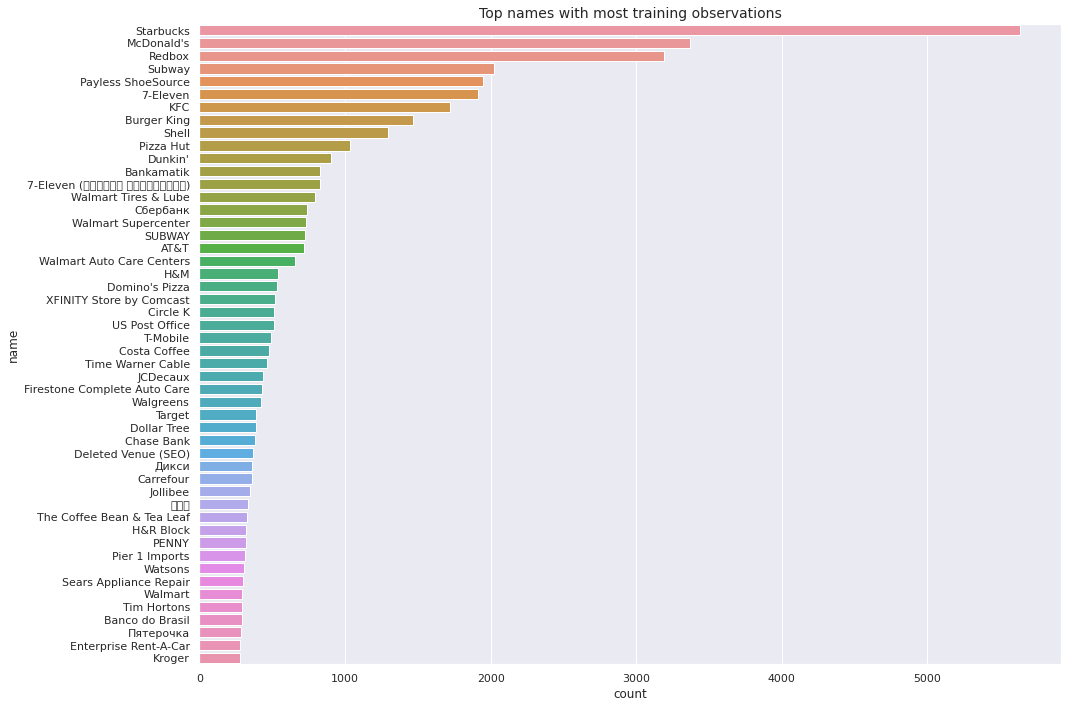

In [53]:
# Horizontal countplots of name of training observations
cutoff = min(len(data_train['name'].value_counts()), 50)
order_descending = data_train.groupby('name').size().sort_values().index[::-1][: cutoff].tolist()
plt.figure(figsize = (15, cutoff / 5))
sns.countplot(data = data_train, y = 'name', order = order_descending)
plt.title("Top names with most training observations", fontsize = 14)
plt.tight_layout()
plt.show()

`Starbucks` tops the list with most highest of training observations, followed by `McDonald's` and `Redbox`.

## Address

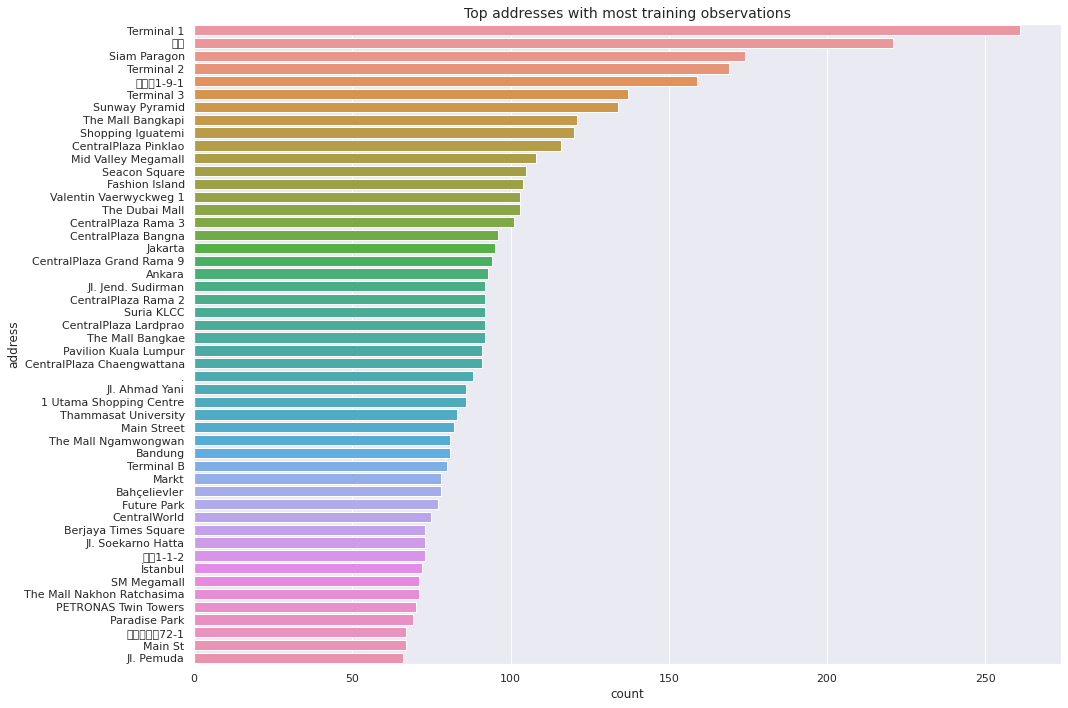

In [54]:
# Horizontal countplots of address of training observations
cutoff = min(len(data_train['address'].value_counts()), 50)
order_descending = data_train.groupby('address').size().sort_values().index[::-1][: cutoff].tolist()
plt.figure(figsize = (15, cutoff / 5))
sns.countplot(data = data_train, y = 'address', order = order_descending)
plt.title("Top addresses with most training observations", fontsize = 14)
plt.tight_layout()
plt.show()

As expected, generic strings that are typically used as part of address feature as the top most addresses of the training observations, with `Terminal 1` having the highest frequency.

## Phone

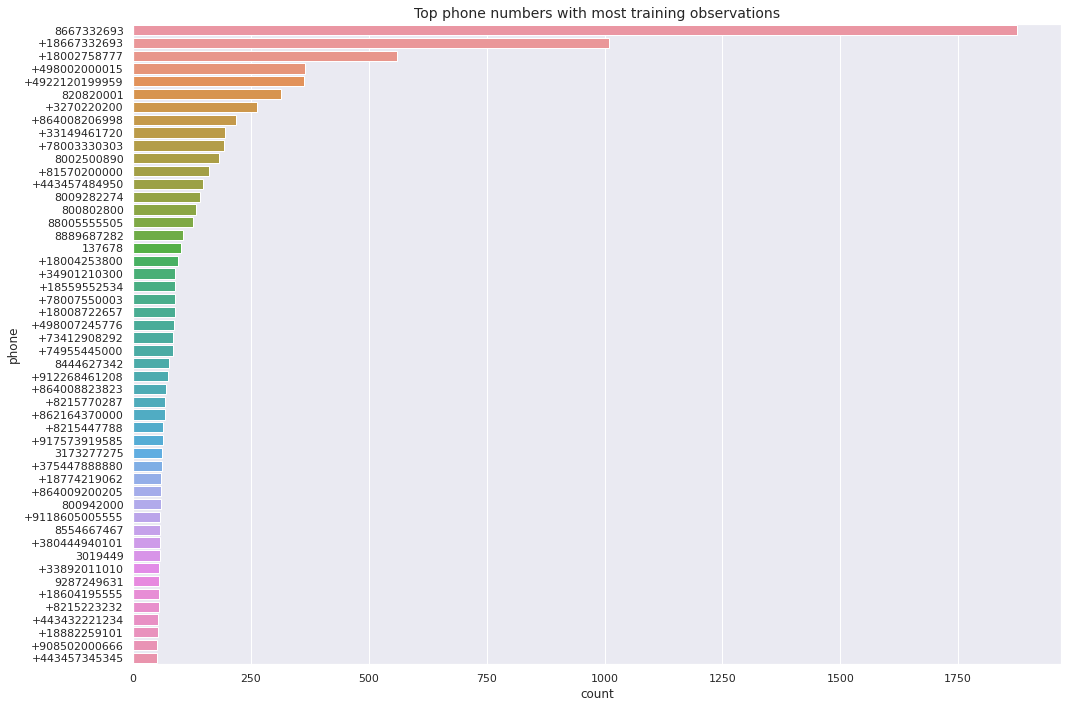

In [55]:
# Horizontal countplots of phone numbers of training observations
cutoff = min(len(data_train['phone'].value_counts()), 50)
order_descending = data_train.groupby('phone').size().sort_values().index[::-1][: cutoff].tolist()
plt.figure(figsize = (15, cutoff / 5))
sns.countplot(data = data_train, y = 'phone', order = order_descending)
plt.title("Top phone numbers with most training observations", fontsize = 14)
plt.tight_layout()
plt.show()

The number `8667332693` leads by far, followed by itself with the extension `+1`. It shows how same phone number can have variation in the records due to addition or omission of extensions. Removing the extensions at the *data preprocessing* stage may be helpful to avoid same phone numbers from getting identified as different.

## URL

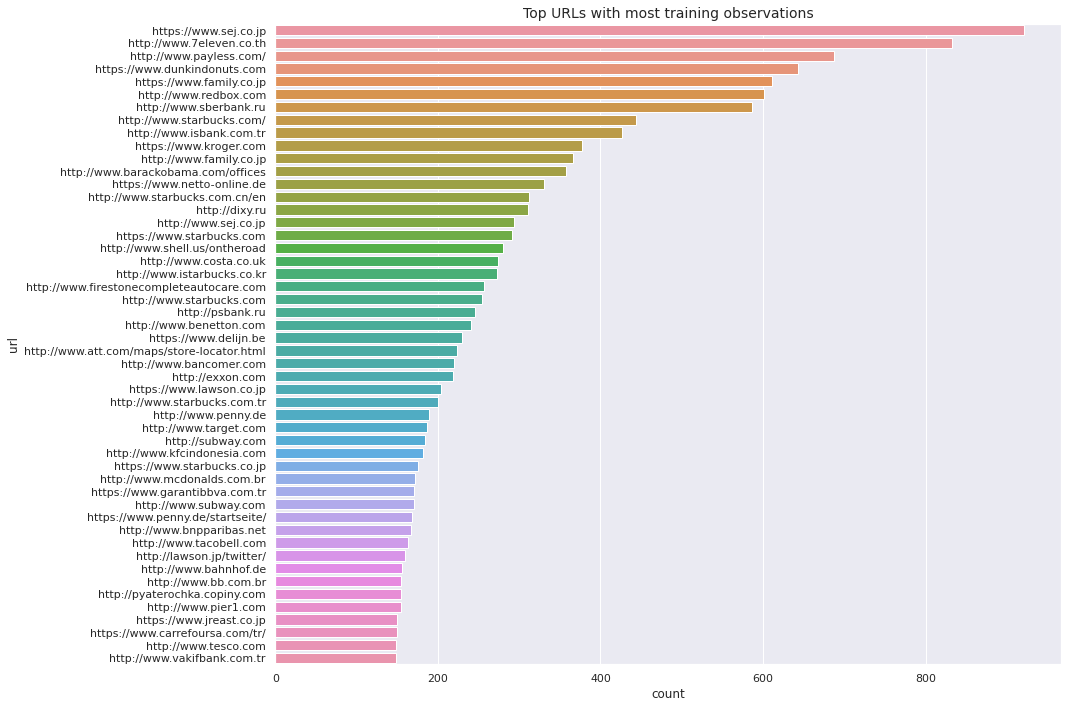

In [56]:
# Horizontal countplots of URL of training observations
cutoff = min(len(data_train['url'].value_counts()), 50)
order_descending = data_train.groupby('url').size().sort_values().index[::-1][: cutoff].tolist()
plt.figure(figsize = (15, cutoff / 5))
sns.countplot(data = data_train, y = 'url', order = order_descending)
plt.title("Top URLs with most training observations", fontsize = 14)
plt.tight_layout()
plt.show()

The website `https://www.sej.co.jp` is associated with the highest number of training observations, followed by `http://www.7eleven.co.th` and `http://www.payless.com/`. Observe the possibility of undesired variation due to the strings `https://`, `http://`, `www` or an appended frontslash at the end. It may be helpful to get rid of these strings and retain only the *core* part of the URLs at the *data preprocessing* stage.

# 4. Multivariate Analysis - Training Set

- Latitude and Longitude
- States of USA
- Cities of California, USA
- ZIP codes of San Francisco, California, USA
- Categories of POIs in San Francisco - 94103, California, USA
- Names of coffee shops in San Francisco - 94103, California, USA
- Address, Phone and URL of Starbucks coffee shops in San Francisco - 94103, California, USA

## Latitude and Longitude

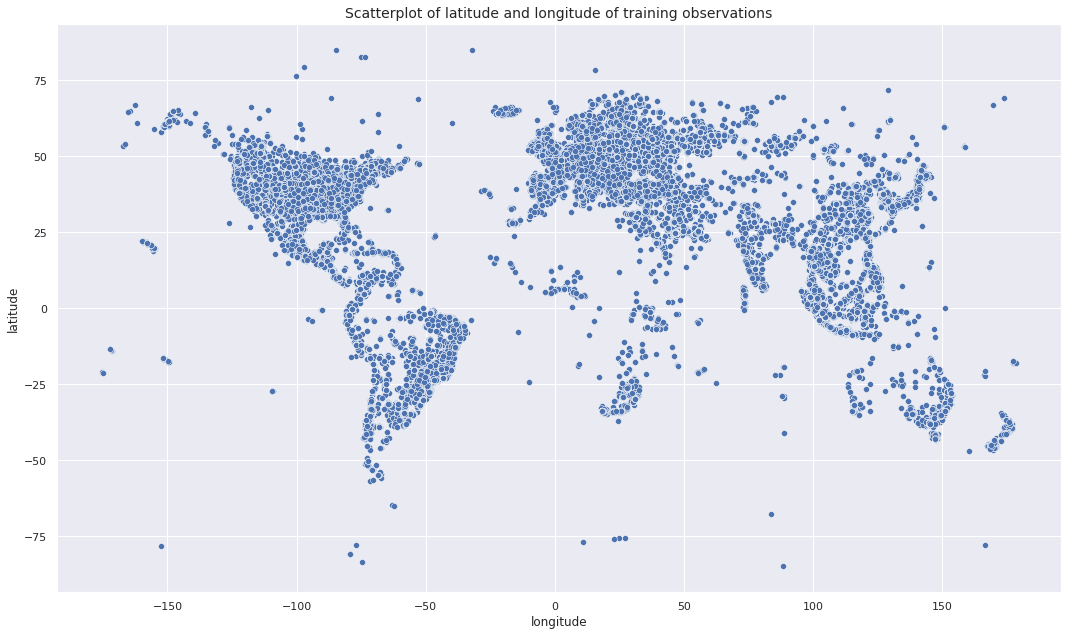

In [57]:
# Scatterplot of latitude and longitude of observations in the training set
plt.figure(figsize = (15, 9))
sns.scatterplot(data = data_train, x = 'longitude', y = 'latitude')
plt.title("Scatterplot of latitude and longitude of training observations", fontsize = 14)
plt.tight_layout()
plt.show()

This scatterplot gives a clearer picture of the locations than the histograms for the latitude and the longitudes of POIs in the training data, as presented in the previous section, because they only captured marginal information on the location of the observations. The present plot roughly resembles the world map, although there are relatively less number of POIs from `Canada`, `Australia`, some parts of `Russia` and the countries from `Africa` (apart from the southeast part). Observations are dense and uniform over `United States of America`, `Mexico`, `New Zealand`, almost entirety of `India`, east coast of `South America`, the countries in `Europe` and `Southeast Asia`, as well as the east coast of `Australia`. Next, we present horizontal countplots of the object-type columns in a hierarchical manner:

$$ \text{World} \mapsto \text{USA} \mapsto \text{California} \mapsto \text{San Francisco} \mapsto \text{ZIP}\,\,94103 \mapsto \text{Coffee Shops} \mapsto \text{Starbucks}$$

## States of USA

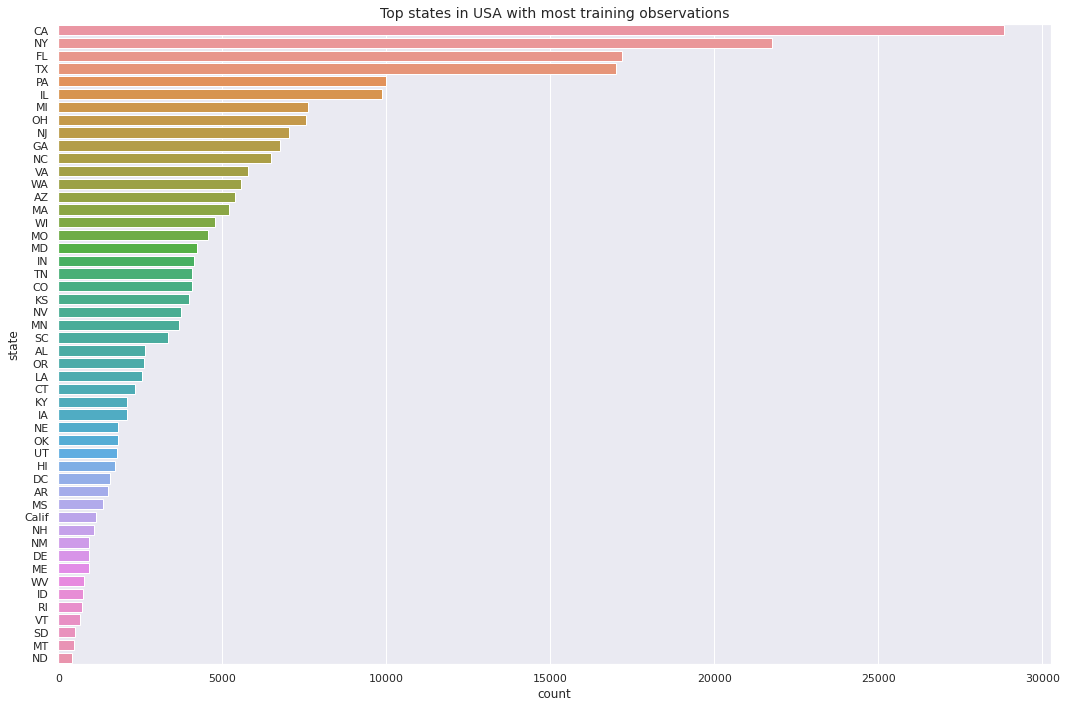

In [58]:
# Horizontal countplot of state of training observations located in the United States of America
data_temp = data_train[data_train['country'] == 'US']
cutoff = min(len(data_temp['state'].value_counts()), 50)
order_descending_temp = data_temp.groupby('state').size().sort_values().index[::-1][: cutoff].tolist()
fig, ax = plt.subplots(1, 1, figsize = (15, cutoff / 5), sharex = True)
sns.countplot(data = data_temp, y = 'state', order = order_descending_temp, ax = ax)
ax.set_title("Top states in USA with most training observations", fontsize = 14)
plt.tight_layout()
plt.show()

In the USA, the state of California (`CA`) comes out on top, followed by New York (`NY`) and Florida (`FL`). In fact, seven of the top ten states in the world are from USA itself. Next we explore the top cities of the state of California, with most training observations.

## Cities of California, USA

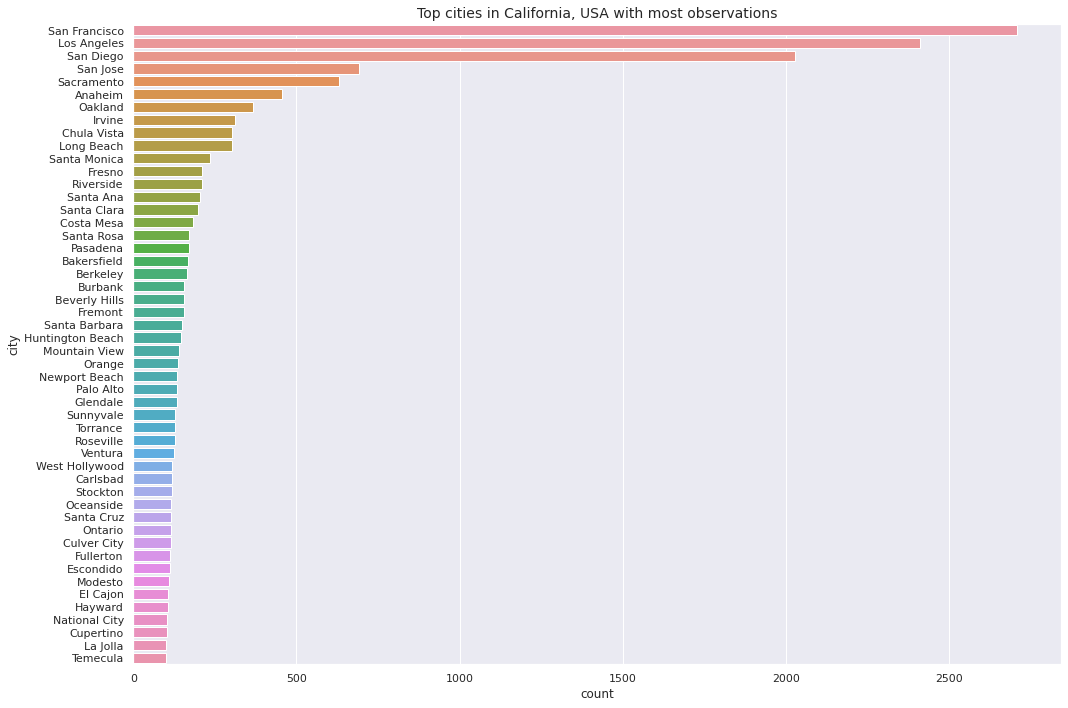

In [59]:
# Horizontal countplot of city of training observations located in the state of California, USA
data_temp = data_train[(data_train['country'] == 'US') 
                       & (data_train['state'] == 'CA')]
cutoff = min(len(data_temp['city'].value_counts()), 50)
order_descending_temp = data_temp.groupby('city').size().sort_values().index[::-1][: cutoff].tolist()
fig, ax = plt.subplots(1, 1, figsize = (15, cutoff / 5), sharex = True)
sns.countplot(data = data_temp, y = 'city', order = order_descending_temp, ax = ax)
ax.set_title("Top cities in California, USA with most observations", fontsize = 14)
plt.tight_layout()
plt.show()

In the state of California, the city of `San Francisco` has most of the training observations, followed closely by `Los Angeles` and `San Diego`. Next we analyze the top ZIP codes in the city of `San Francisco`, covering most training observations.

## ZIP codes of San Francisco, California, USA

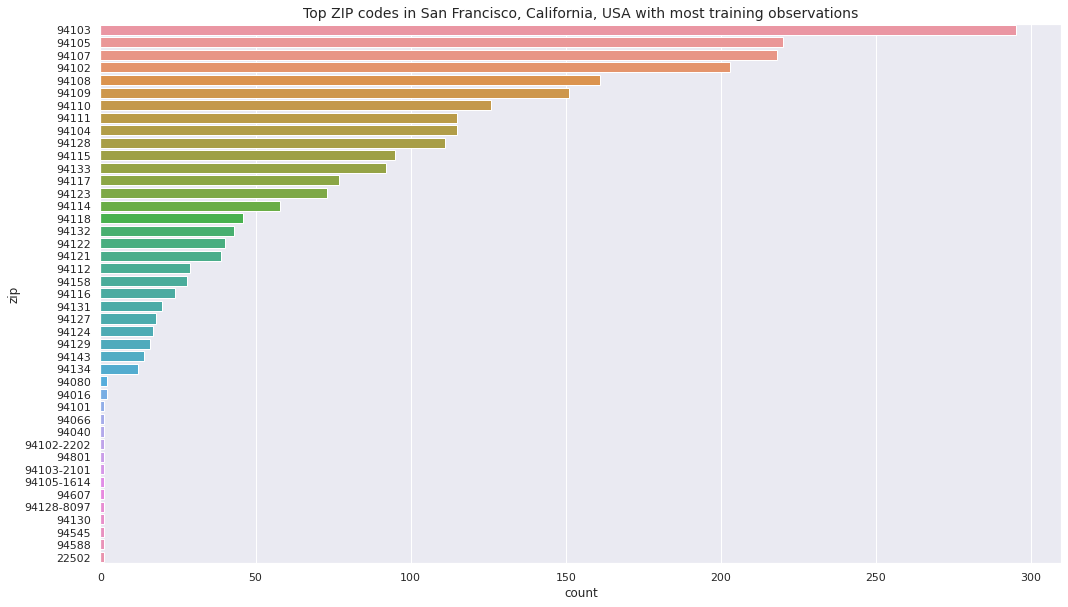

In [60]:
# Horizontal countplot of ZIP code of training observations in the city of San Francisco, state of California, USA
data_temp = data_train[(data_train['country'] == 'US') 
                       & (data_train['state'] == 'CA') 
                       & (data_train['city'] == 'San Francisco')]
cutoff = min(len(data_temp['zip'].value_counts()), 50)
order_descending_temp = data_temp.groupby('zip').size().sort_values().index[::-1][: cutoff].tolist()
fig, ax = plt.subplots(1, 1, figsize = (15, cutoff / 5), sharex = True)
sns.countplot(data = data_temp, y = 'zip', order = order_descending_temp, ax = ax)
ax.set_title("Top ZIP codes in San Francisco, California, USA with most training observations", fontsize = 14)
plt.tight_layout()
plt.show()

We observe that in the city of `San Francisco`, the ZIP code with highest number of training observations is `94103`, followed by `94105`, `94107` and `94102`. We shall move onto the *categories* of the POIs and focus only on the observations from `San Francisco - 94103`.

## Categories of POIs in San Francisco - 94103, California, USA

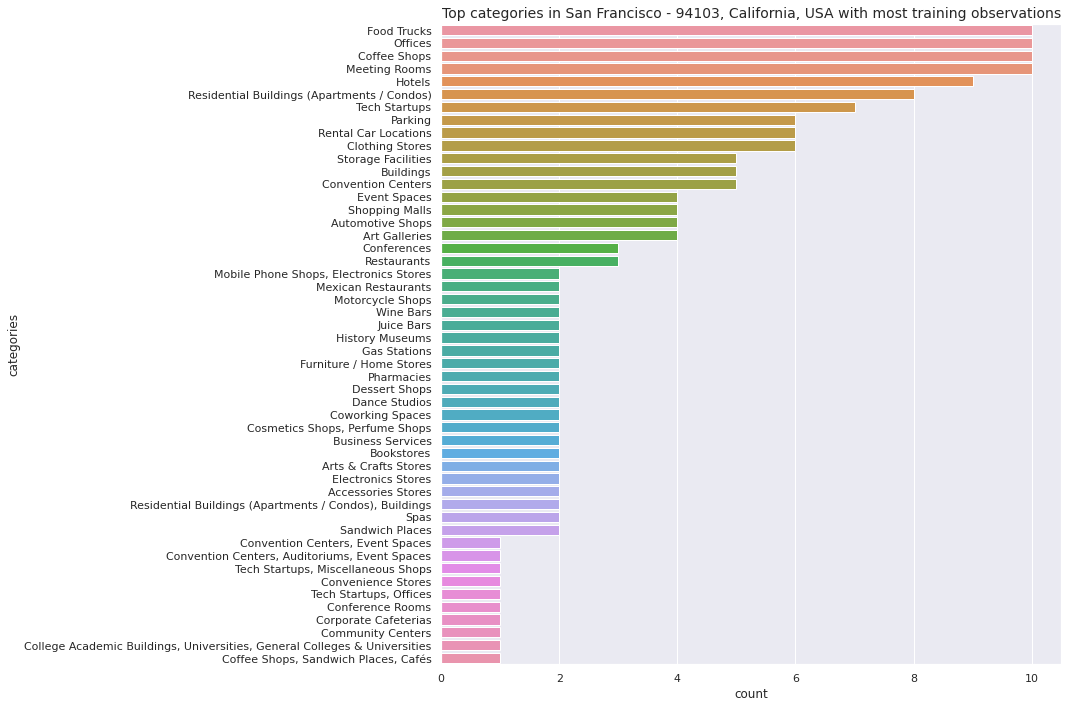

In [61]:
# Horizontal countplot of categories of training observations in the city of San Francisco - 94103, state of California, USA
data_temp = data_train[(data_train['country'] == 'US') 
                       & (data_train['state'] == 'CA') 
                       & (data_train['city'] == 'San Francisco') 
                       & (data_train['zip'] == '94103')]
cutoff = min(len(data_temp['categories'].value_counts()), 50)
order_descending = data_temp.groupby('categories').size().sort_values().index[::-1][: cutoff].tolist()
plt.figure(figsize = (15, cutoff / 5))
sns.countplot(data = data_temp, y = 'categories', order = order_descending)
plt.title("Top categories in San Francisco - 94103, California, USA with most training observations", fontsize = 14)
plt.tight_layout()
plt.show()

Four categories have highest number of training observations in the specified ZIP code: `Food Trucks`, `Meeting Rooms`, `Offices` and `Coffee Shops`. Next we shall see the `name` of the `Coffee Shops` in `San Francisco - 94103, California, USA` region considered above.

## Names of coffee shops in San Francisco - 94103, California, USA

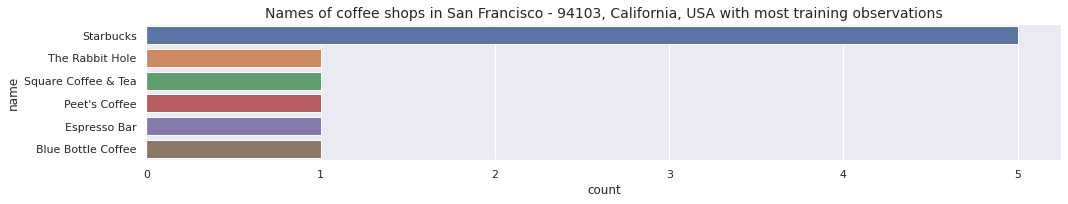

In [62]:
# Horizontal countplot of names of training observations which are coffee shops in the city of San Francisco - 94103, state of California, USA
data_temp = data_train[(data_train['country'] == 'US') 
                       & (data_train['state'] == 'CA') 
                       & (data_train['city'] == 'San Francisco') 
                       & (data_train['zip'] == '94103') 
                       & (data_train['categories'] == 'Coffee Shops')]
cutoff = min(len(data_temp['name'].value_counts()), 75)
order_descending = data_temp.groupby('name').size().sort_values().index[::-1][: cutoff].tolist()
plt.figure(figsize = (15, cutoff / 2))
sns.countplot(data = data_temp, y = 'name', order = order_descending)
plt.title("Names of coffee shops in San Francisco - 94103, California, USA with most training observations", fontsize = 14)
plt.tight_layout()
plt.show()

We observe that there are five`Starbucks` coffee shops in the region. We shall check `address`, `phone` and `url` to see if any pair of these shops are identical.

## Address, Phone and URL of Starbucks coffee shops in San Francisco - 94103, California, USA

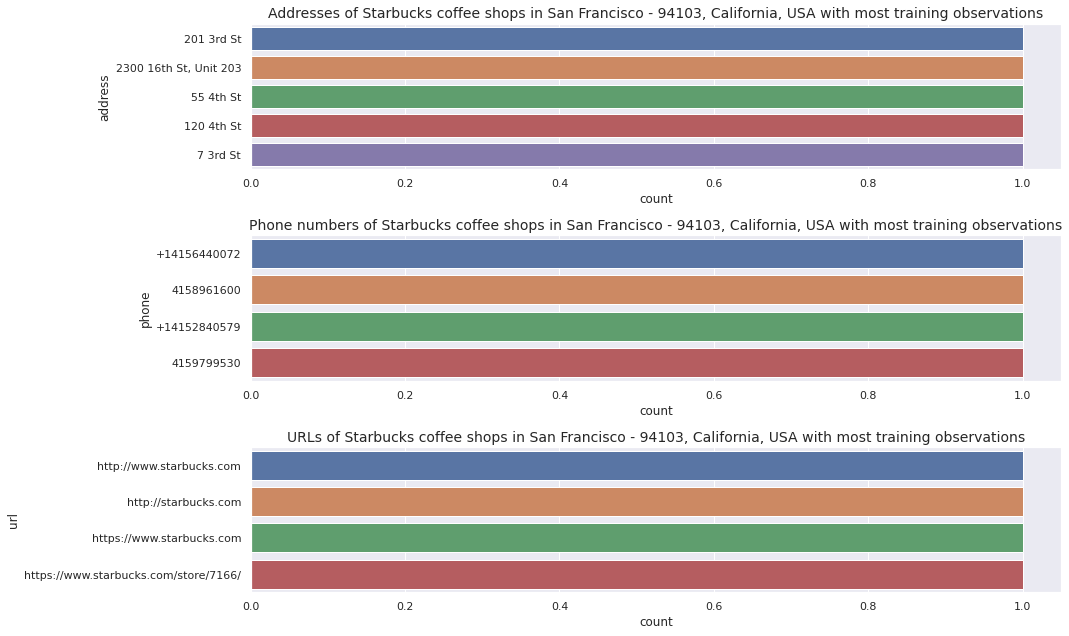

In [63]:
# Horizontal countplots of address, phone and url of training observations which are coffee shops in the city of San Francisco - 94103, state of California, USA
data_temp = data_train[(data_train['country'] == 'US') 
                       & (data_train['state'] == 'CA') 
                       & (data_train['city'] == 'San Francisco') 
                       & (data_train['zip'] == '94103') 
                       & (data_train['categories'] == 'Coffee Shops')
                       & (data_train['name'] == 'Starbucks')]
fig, ax = plt.subplots(3, 1, figsize = (15, 9))
sns.countplot(data = data_temp, y = 'address', ax = ax[0])
ax[0].set_title("Addresses of Starbucks coffee shops in San Francisco - 94103, California, USA with most training observations", fontsize = 14)
sns.countplot(data = data_temp, y = 'phone', ax = ax[1])
ax[1].set_title("Phone numbers of Starbucks coffee shops in San Francisco - 94103, California, USA with most training observations", fontsize = 14)
sns.countplot(data = data_temp, y = 'url', ax = ax[2])
ax[2].set_title("URLs of Starbucks coffee shops in San Francisco - 94103, California, USA with most training observations", fontsize = 14)
plt.tight_layout()
plt.show()

Thus all the Starbucks coffee shops in the region have distinct addresses, indicating that there are no matches among them. Furthermore the available *phone* numbers (which is missing for one out of the five shops) are also distinct. Note that the available urls, though appear distinct, have many matches and are only distinct due to variations in *https*, *http*, *www* etc. One may get rid of strings like *https://*, *http://*, *www.*, *https://www.*, *http://www.* etc to overcome this issue.

# 5. Univariate Analysis - Pairs Set

- Match
- Feature Based on Latitude and Longitude
- Features Based on Levenshtein Distance
- Features Based on Largest Common Substring
- Features Based on Matching
- Distance between Locations
- Distance between Names
- Distance between Addresses
- Distance between URLs
- Distance between Phone Numbers
- Matching of Countries
- Matching of States
- Matching of Cities
- Matching of ZIP Codes
- Matching of Categories

In [64]:
# Barplot and donutplot of a categorical column of a dataframe
def count(df, col):
    """
    Prints barplot and donutplot of a categorical column of a dataframe
    Args:
      df (DataFrame):       dataframe with categorical column col
      col (usually string): name of a categorical column of df
    
    Returns:
      Nothing, prints barplot and donutplot of df[col]
    """
    fig = make_subplots(rows = 1, cols = 2, specs = [[{'type': 'xy'}, {'type': 'domain'}]])
    x_val = df[col].value_counts(sort = False).index.tolist()
    y_val = df[col].value_counts(sort = False).tolist()
    fig.add_trace(go.Bar(x = x_val, y = y_val, text = y_val, textposition = 'auto'), row = 1, col = 1)
    fig.add_trace(go.Pie(values = y_val, labels = x_val, hole = 0.5, textinfo = 'label+percent', title = f"{col}"), row = 1, col = 2)
    fig.update_layout(height = 500, width = 800, showlegend = False, xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1), title = dict(text = f"Frequency distribution of {col}", x = 0.5, y = 0.95)) 
    fig.show()

## Match

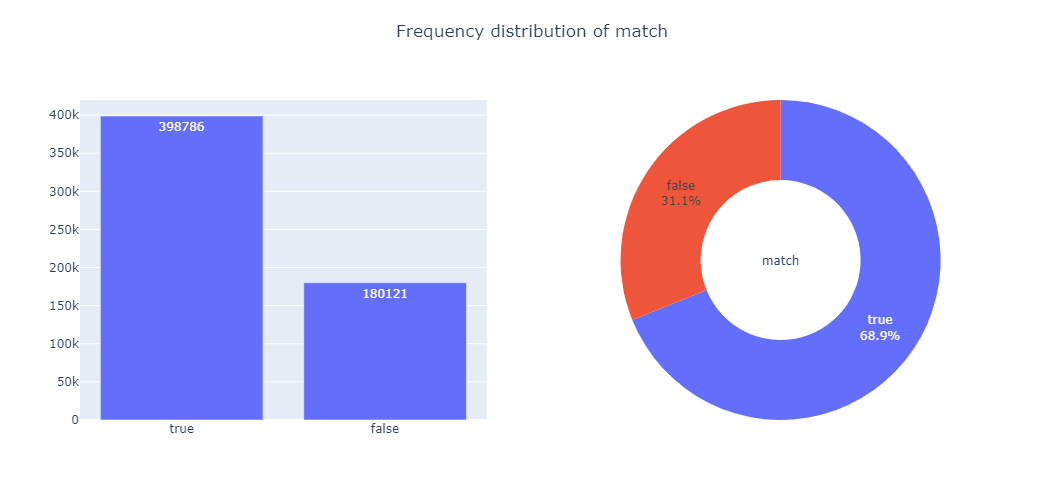

In [65]:
# Barplot and donutplot of the 'match' column
count(data_pairs, 'match')

We observe that $68.9\%$ of the pairs in the pregenerated set of pairs match, while $31.1\%$ of the pairs do not match. Next, we consider a typical observation from the pairs data.

In [66]:
# Typical observation from the pregenerated set of pairs
data_pairs.iloc[0]

id_1                E_000001272c6c5d
name_1          Café Stad Oudenaarde
latitude_1                 50.859975
longitude_1                 3.634196
address_1                Abdijstraat
city_1                    Nederename
state_1              Oost-Vlaanderen
zip_1                           9700
country_1                         BE
url_1                            NaN
phone_1                          NaN
categories_1                    Bars
id_2                E_da7fa3963561f8
name_2               Café Oudenaarde
latitude_2                 50.869358
longitude_2                 3.635206
address_2                        NaN
city_2                           NaN
state_2                          NaN
zip_2                            NaN
country_2                         BE
url_2                            NaN
phone_2                          NaN
categories_2                    Bars
match                           True
Name: 0, dtype: object

It contains a pair of observations. The *id* of the two observations are expectedly different. The *name* is slightly different, as are the *latitude* and *longitude*. *Country* and *category* are identical. Some of the attributes are missing in one of the observations, while some are missing in both. The target variable here is `match`, which is a Boolean variable taking the value `True` if the two observations refer to the same POI and `False` otherwise. We observe that the number of features can be greatly reduced if we focus on the information that are relevant in predicting `match`, and discard the rest. We initiate a dataframe to extract and store these relevant information out of the attributes in `data_pairs`.

In [67]:
# Dataframe initialization for new features based on the pregenerated set of pairs
data_pairs_feat = pd.DataFrame()

## Feature Based on Latitude and Longitude

The information that is relevant in predicting `match`, contained in `latitude_1`, `longitude_1`, `latitude_2` and `longitude_2`, can be encapsulated into a single variable, which is the distance `dist_loc` between the two locations (`latitude_1`, `longitude_1`) and (`latitude_2`, `longitude_2`), given by the [haversine formula](https://en.wikipedia.org/wiki/Haversine_formula). The haversine formula computes the [great-circle distance](https://en.wikipedia.org/wiki/Great-circle_distance) between two points on a sphere, given their latitudes and longitudes. In other words, it gives the distance between the two points *over the surface*, which is not same as the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance), which gives the length of the straight line joining the two points. Let $\left(\phi_1, \lambda_1\right)$ and $\left(\phi_2, \lambda_2\right)$ be the coordinates of two POIs. Then the distance between the two POIs is

$$ d = 2r \arcsin\left(\sqrt{\text{hav}\left(\phi_1 - \phi_2\right) + \text{cos}\left(\phi_1\right) \text{cos}\left(\phi_2\right) \text{hav}\left(\lambda_1 - \lambda_2\right)}\right), $$

where

$$ \text{hav}\left(\theta\right) = \sin^2\left(\frac{\theta}{2}\right) = \frac{1-\cos{\theta}}{2}. $$

In [68]:
# Haversine formula
def dist(lat1, lon1, lat2, lon2):
    """
    Computes the distance (over the surface) between two coordinates (lat1, lon1) and (lat2, lon2) in km
    Args:
      lat1 (float): latitude of first location
      lon1 (float): longitude of first location
      lat2 (float): latitude of second location
      lon2 (float): longitude of second location
      
    Returns:
      d (float): distance between the two locations in km
    """
    r = 6371
    lat1, lon1, lat2, lon2 = np.radians(lat1), np.radians(lon1), np.radians(lat2), np.radians(lon2)
    dlat, dlon = lat1 - lat2, lon1 - lon2
    h = ((1 - cos(dlat)) / 2) + (cos(lat1) * cos(lat2) * ((1 - cos(dlon)) / 2))
    d = 2 * r * asin(sqrt(h))
    return d

lat1, lon1, lat2, lon2 = 5.012169, 100.535805, 40.434209, -80.564160
print(f"Input: ({lat1}, {lon1}) and ({lat2}, {lon2})")
print(f"Output: {dist(lat1, lon1, lat2, lon2)} km")

Input: (5.012169, 100.535805) and (40.434209, -80.56416)
Output: 14960.43102103062 km


In [69]:
# Distance between locations
dist_loc = [dist(data_pairs['latitude_1'][i], data_pairs['longitude_1'][i], data_pairs['latitude_2'][i], data_pairs['longitude_2'][i]) for i in data_pairs.index]
data_pairs_feat['dist_loc'] = dist_loc

## Features Based on Levenshtein Distance

In the typical observation printed at the beginning of the section, we see the name of the same POI is reported as `Café Stad Oudenaarde` in one record, and `Café Oudenaarde` in another. We use a quantification of distance between two strings to capture the extent of this difference between the reported names of a pair of observations. For example, we would expect the difference between `Café Stad Oudenaarde` and `Café Oudenaarde` to be lesser than the same between `Turkcell` and `Island Spa Theater`. Here we shall employ the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance), which measures the difference between two sequences. It is named after the Soviet mathematician [Vladimir Levenshtein](https://en.wikipedia.org/wiki/Vladimir_Levenshtein), who considered this distance in 1965. Informally, the Levenshtein distance between two words is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other. Mathematically, the Levenshtein distance between two strings $a$ and $b$ (of length $\left\vert a \right\vert$ and $\left\vert b \right\vert$ respectively) is defined recursively as

$$ \text{lev(a, b)} =
\left\{
    \begin{array}{ll}
        \left\vert a \right\vert, & \mbox{if } \left\vert b \right\vert = 0, \\
        \left\vert b \right\vert, & \mbox{if } \left\vert a \right\vert = 0, \\
        \text{lev(tail(a), tail(b))}, & \mbox{if } a[0] = b[0], \\
        1 + \min \left\{
                     \begin{array}{l}
                         \text{lev(tail(a), b)} \\
                         \text{lev(a, tail(b))} \\
                         \text{lev(tail(a), tail(b))}
                     \end{array}
                 \right., & \mbox{otherwise},
    \end{array}
\right. $$

where the *tail* of some string $x$ is a string of all but the first character of $x$, for example `tail('Levenshtein') == 'evenshtein'`, and $x[n]$ is the $n$th character of the string $x$, counting from $0$, for example `'Levenshtein'[0] == 'L'`. Note that the first element in the minimum, `lev(tail(a), b)`, corresponds to *deletion* (from $a$ to $b$), the second `lev(a, tail(b))` to *insertion* and the third `lev(tail(a), tail(b))` to *replacement*.

In [70]:
# Recursive function to compute Levenshtein distance
def lev(str1, str2):
    """
    Computes Levenshtein distance between two strings
    Args:
      str1 (string): a general string
      str2 (string): a general string

    Returns:
      lev_dist (int): Levenshtein distance between the two strings str1 and str2
    """
    @lru_cache(None)
    def min_dist(s1, s2):
        if len(str1) == s1:
            return len(str2) - s2
        elif len(str2) == s2:
            return len(str1) - s1
        elif str1[s1] == str2[s2]:
            return min_dist(s1 + 1, s2 + 1)
        else:
            return 1 + min(
                min_dist(s1, s2 + 1),
                min_dist(s1 + 1, s2),
                min_dist(s1 + 1, s2 + 1)
            )
    lev_dist = min_dist(0, 0)
    return lev_dist

In [71]:
# Computation of Levenshtein distance for two examples
lev1 = lev('Café Stad Oudenaarde', 'Café Oudenaarde')
lev2 = lev('Turkcell', 'Island Spa Theater')
print(pd.Series({"Levenshtein distance between 'Café Stad Oudenaarde' and 'Café Oudenaarde'": lev1,
                 "Levenshtein distance between 'Turkcell' and 'Island Spa Theater'": lev2}).to_string())

Levenshtein distance between 'Café Stad Oudenaarde' and 'Café Oudenaarde'     5
Levenshtein distance between 'Turkcell' and 'Island Spa Theater'             17


We observe in the pregenerated set of pairs that often `name`, `address`, `url`, `phone` for the same POI varies in different records for variety of reasons. Some records may contain shortened versions of the names. Addresses may vary in the depth of detailing. URLs may vary by presence or omission of strings like *http*, *https*, *www*. Phone numbers may vary due to extensions, brackets, space and symbols like $+$ or hyphen. For these reasons, we create distance features based on these attributes using the Levenshtein distance. Note that we have to convert some of the input data to string format before feeding it to the function that computes the distance.

In [72]:
# New features based on Levenshtein distance
dist_name_list = []
dist_address_list = []
dist_url_list = []
dist_phone_list = []

for i in range(len(data_pairs)):
    dist_name_list.append(lev(data_pairs['name_1'][i], data_pairs['name_2'][i]))
    dist_address_list.append(lev(str(data_pairs['address_1'][i]), str(data_pairs['address_2'][i])))
    dist_url_list.append(lev(str(data_pairs['url_1'][i]), str(data_pairs['url_2'][i])))
    dist_phone_list.append(lev(str(data_pairs['phone_1'][i]), str(data_pairs['phone_2'][i])))

data_pairs_feat['dist_name'] = dist_name_list
data_pairs_feat['dist_address'] = dist_address_list
data_pairs_feat['dist_url'] = dist_url_list
data_pairs_feat['dist_phone'] = dist_phone_list

## Features Based on Largest Common Substring

As an alternative approach to the one based on Levenshtein distance, we create similarity measures for the object-type variables, using the length of the largest common substring of two strings, relative to the length of the shorter string. Note that we may have to convert some of the input data to string format before feeding it to the function that computes this quantity.

In [73]:
# Relative length proportion of largest common substring of two strings
def lcss(str1, str2):
    """
    Computes length proportion of largest common substring of two strings, relative to the length of the shorter string
    Args:
      str1 (string): a general string
      str2 (string): a general string

    Returns:
      prop (float): length of the largest common substring of two strings, scaled by length of the shorter string
    """
    n1, n2 = len(str1), len(str2)
    lc = [[0 for k in range(n2 + 1)] for l in range(n1 + 1)]
    out = 0
    for i in range(n1 + 1):
        for j in range(n2 + 1):
            if (i == 0 or j == 0):
                lc[i][j] = 0
            elif (str1[i-1] == str2[j-1]):
                lc[i][j] = lc[i-1][j-1] + 1
                out = max(out, lc[i][j])
            else:
                lc[i][j] = 0
    prop = out / min(n1, n2)
    return prop

str1, str2 = '118th street bus stop', '118th street beach'
print(f"Input: '{str1}' and '{str2}'")
print(f"Output: {lcss(str1, str2)}")

Input: '118th street bus stop' and '118th street beach'
Output: 0.7777777777777778


In [74]:
# New features based on Levenshtein distance
lcss_name_list = []
lcss_address_list = []
lcss_url_list = []
lcss_phone_list = []

for i in range(len(data_pairs)):
    lcss_name_list.append(lcss(data_pairs['name_1'][i], data_pairs['name_2'][i]))
    lcss_address_list.append(lcss(str(data_pairs['address_1'][i]), str(data_pairs['address_2'][i])))
    lcss_url_list.append(lcss(str(data_pairs['url_1'][i]), str(data_pairs['url_2'][i])))
    lcss_phone_list.append(lcss(str(data_pairs['phone_1'][i]), str(data_pairs['phone_2'][i])))

data_pairs_feat['lcss_name'] = lcss_name_list
data_pairs_feat['lcss_address'] = lcss_address_list
data_pairs_feat['lcss_url'] = lcss_url_list
data_pairs_feat['lcss_phone'] = lcss_phone_list

## Features Based on Matching

As there are no scope of confusion about the country of a POI, the two features `country_1` and `country_2` can be replaced by a binary variable `country_match` which is `True` when `country_1 == country_2` and `False` otherwise.

$$ \text{match_country} =
\left\{
    \begin{array}{ll}
        \text{True,}  & \mbox{if country_1 = country_2,}\\
        \text{False,} & \mbox{otherwise.}
    \end{array}
\right. $$

If `match_country == False` then it is a certain indication towards `match == False`. Similarly, we can construct `match_city`, `match_state`, `match_zip`, `match_categories`, respectively based on the columns on `city`, `state`, `zip`, `phone`, `categories`. We keep the `match` column as it is.

In [75]:
# New features based on matching
def condition(df, col1, col2, i):
    return (str(df[col1][i]) == 'nan' or str(df[col2][i]) == 'nan')
def value(df, col1, col2, i):
    return (df[col1][i] == df[col2][i])
def match_list(df, col1, col2):
    return [np.nan if condition(df, col1, col2, i) else value(df, col1, col2, i) for i in range(len(df))]

data_pairs_feat['match_country'] = match_list(data_pairs, 'country_1', 'country_2')
data_pairs_feat['match_city'] = match_list(data_pairs, 'city_1', 'city_2')
data_pairs_feat['match_state'] = match_list(data_pairs, 'state_1', 'state_2')
data_pairs_feat['match_zip'] = match_list(data_pairs, 'zip_1', 'zip_2')
data_pairs_feat['match_categories'] = match_list(data_pairs, 'categories_1', 'categories_2')
data_pairs_feat['match'] = data_pairs['match']

In [76]:
# Dataframe of new features and match, based on the pregenerated set of pairs
print(pd.Series({"Memory usage": "{:.2f} MB".format(data_pairs_feat.memory_usage().sum()/(1024*1024)),
                 "Dataframe shape": "{}".format(data_pairs_feat.shape)}).to_string())
print(" ")
data_pairs_feat.head()

Memory usage           62.39 MB
Dataframe shape    (578907, 15)
 


dist_loc  dist_name  dist_address  dist_url  dist_phone  lcss_name  \
0  1.045708          5            10         0           0   0.733333   
1  0.731471          0            20         0           0   1.000000   
2  0.140505          8            41         0           0   1.000000   
3  0.015735         14            22        68          10   0.166667   
4  0.702437          2            16         0           0   0.666667   

   lcss_address  lcss_url  lcss_phone match_country match_city match_state  \
0      0.333333  1.000000         1.0          True        NaN         NaN   
1      0.100000  1.000000         1.0          True        NaN         NaN   
2      0.666667  1.000000         1.0          True        NaN         NaN   
3      0.333333  0.333333         0.0          True       True        True   
4      0.153846  1.000000         1.0          True       True        True   

  match_zip match_categories  match  
0       NaN             True   True  
1       NaN            False  False  
2       NaN             True   True  
3       NaN             True   True  
4      True            False  False

## Distance between Locations

This variable is extremely skewed. To deal with it, we have applied the following transformation: $x \mapsto log(x+\epsilon),$ where $\epsilon$ is a very small positive real number. Here we have taken $\epsilon = 0.00000001$. The reason behind making this small shift to the data is that the log function maps $0$ to $-\infty$. The shift keeps the transformed data finite, and keeping $\epsilon$ small ensures that the data points which were originally $0,$ stands out from the rest in the transformed setup. Visualizations of the distribution of both the original feature and the transformed feature have been shown.

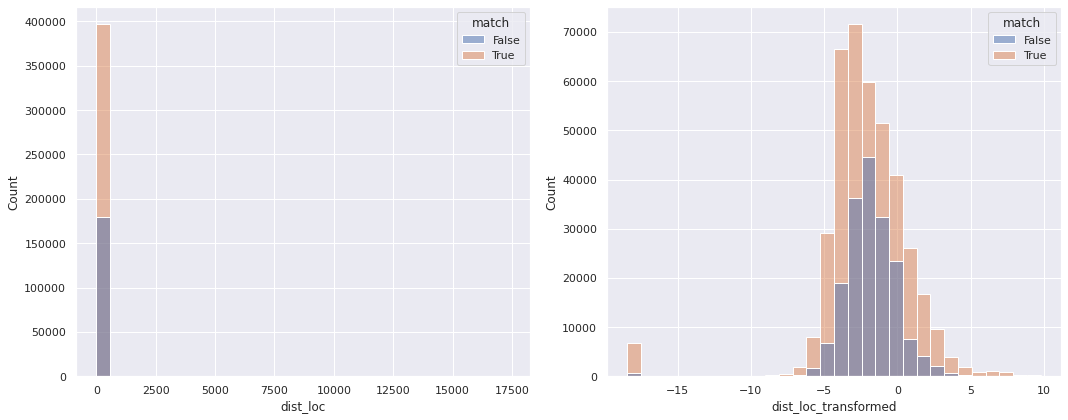

In [77]:
# Histogram of distance between locations
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharex = False, sharey = False)
data_temp = data_pairs_feat.copy(deep = True)
epsilon = 0.00000001
data_temp['dist_loc_transformed'] = data_temp['dist_loc'].apply(lambda x: np.log(x + epsilon))
sns.histplot(data = data_temp, x = 'dist_loc', bins = 30, hue = 'match', ax = ax[0])
sns.histplot(data = data_temp, x = 'dist_loc_transformed', bins = 30, hue = 'match', ax = ax[1])
plt.tight_layout()
plt.show()

## Distance between Names

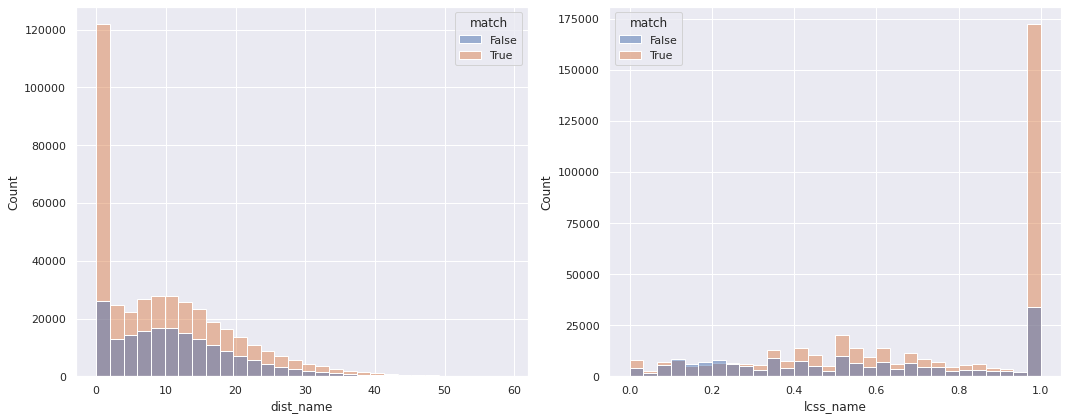

In [78]:
# Histogram of distance between names
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharex = False, sharey = False)
sns.histplot(data = data_pairs_feat, x = 'dist_name', bins = 30, hue = 'match', ax = ax[0])
sns.histplot(data = data_pairs_feat, x = 'lcss_name', bins = 30, hue = 'match', ax = ax[1])
plt.tight_layout()
plt.show()

## Distance between Addresses

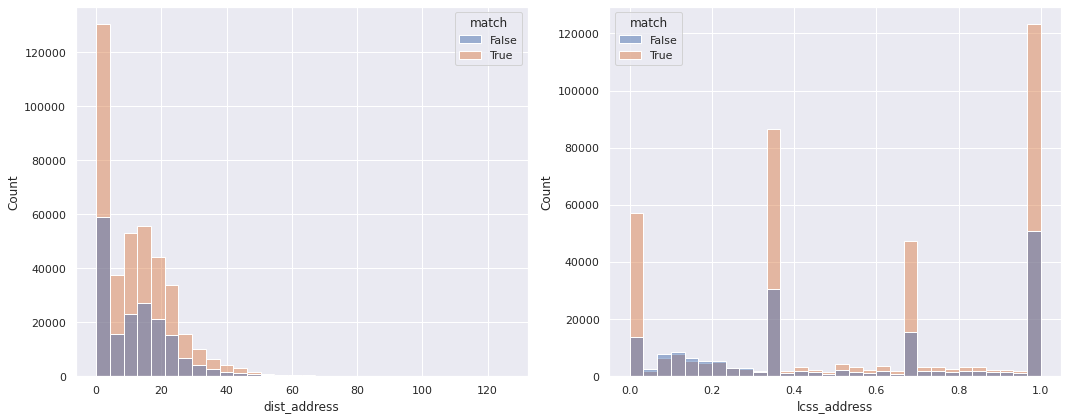

In [79]:
# Histogram of distance between addresses
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharex = False, sharey = False)
sns.histplot(data = data_pairs_feat, x = 'dist_address', bins = 30, hue = 'match', ax = ax[0])
sns.histplot(data = data_pairs_feat, x = 'lcss_address', bins = 30, hue = 'match', ax = ax[1])
plt.tight_layout()
plt.show()

In the plot of Levenshtein distance between the addresses of paired observations, apart from the global peak at $0,$ we observe a noticeable local peak between $10$ and $15$. The reasons behind this local peak may be more than one. It may happen that the addresses are short, and hence the Leveshtein distance between the two addresses in a pair is small. It may also happen that the two observations in the pair report the same address, but at different level of detailing, which surely contributes to substantial amount of pairs with Leveshtein distance between addresses more than $0,$ but less than $15$.

## Distance between URLs

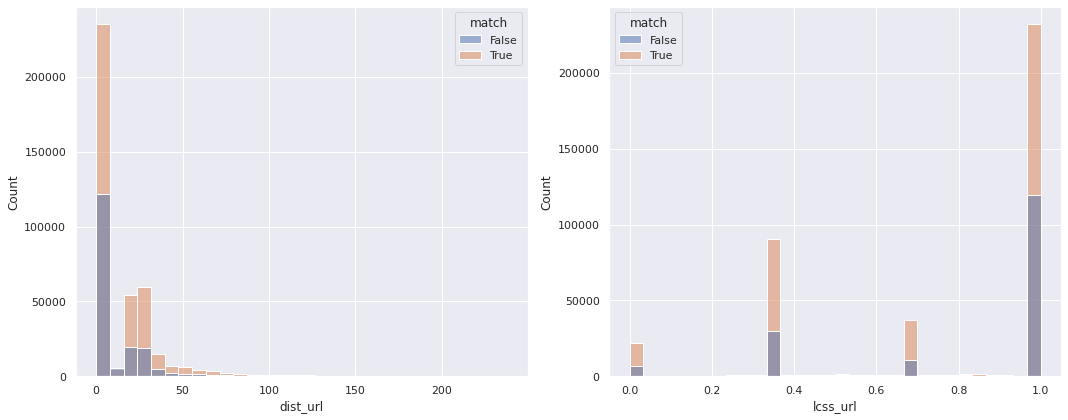

In [80]:
# Histogram of distance between URLs
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharex = False, sharey = False)
sns.histplot(data = data_pairs_feat, x = 'dist_url', bins = 30, hue = 'match', ax = ax[0])
sns.histplot(data = data_pairs_feat, x = 'lcss_url', bins = 30, hue = 'match', ax = ax[1])
plt.tight_layout()
plt.show()

## Distance between Phone Numbers

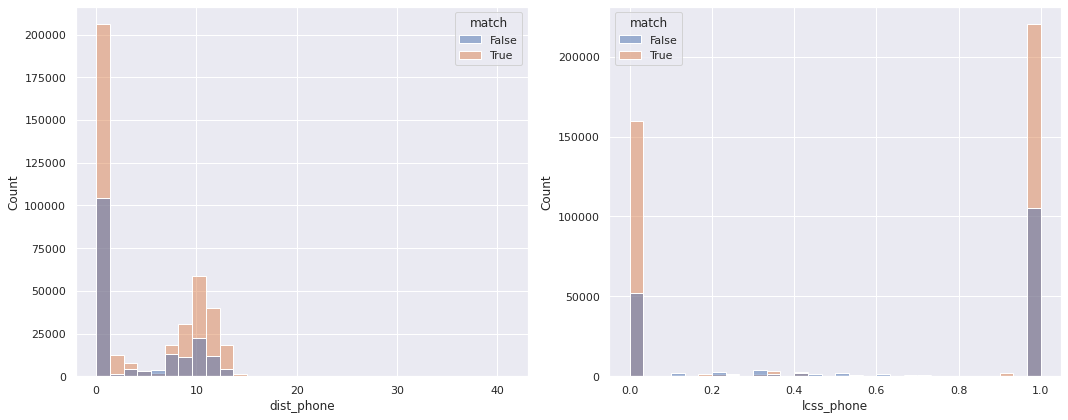

In [81]:
# Histogram of distance between phone numbers
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharex = False, sharey = False)
sns.histplot(data = data_pairs_feat, x = 'dist_phone', bins = 30, hue = 'match', ax = ax[0])
sns.histplot(data = data_pairs_feat, x = 'lcss_phone', bins = 30, hue = 'match', ax = ax[1])
plt.tight_layout()
plt.show()

The local peak around $10,$ which is expected, as most phone numbers have $10$ digits. Thus two different phone numbers of $10$ digits, for which none of the digits are same, has Leveshtein distance $10$ (as it requires $10$ substitutions to go from one number to the another). Of course, it can be more because country extension codes can be involved.

## Matching of Countries

In [82]:
# Frequency distribution of a categorical feature by Boolean target classes
def donut(df, col, boolean_target):
    """
    Prints donutplots of a categorical column of a dataframe, by different classes of a Boolean target variable
    Args:
      df (DataFrame):                  dataframe having the columns col and boolean_target
      col (usually string):            name of a categorical column of df
      boolean_target (usually string): name of a Boolean column of df
      
    Returns:
      Nothing, prints donutplots of df[col] for different values of boolean_target
"""
    fig = make_subplots(rows = 1, cols = 2, specs = [[{'type': 'domain'}, {'type': 'domain'}]])
    x_val_true = df[df[boolean_target] == True][col].value_counts(sort = False).index.tolist()
    y_val_true = df[df[boolean_target] == True][col].value_counts(sort = False).tolist()
    fig.add_trace(go.Pie(values = y_val_true, labels = x_val_true, hole = 0.5, textinfo = 'label+percent', title = f"{boolean_target} = True"), row = 1, col = 1)
    x_val_false = df[df[boolean_target] == False][col].value_counts(sort = False).index.tolist()
    y_val_false = df[df[boolean_target] == False][col].value_counts(sort = False).tolist()
    fig.add_trace(go.Pie(values = y_val_false, labels = x_val_false, hole = 0.5, textinfo = 'label+percent', title = f"{boolean_target} = False"), row = 1, col = 2)
    fig.update_layout(height = 500, width = 800, showlegend = False, xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1), title = dict(text = f"Frequency distribution of {col} by {boolean_target}", x = 0.5, y = 0.95)) 
    fig.show()

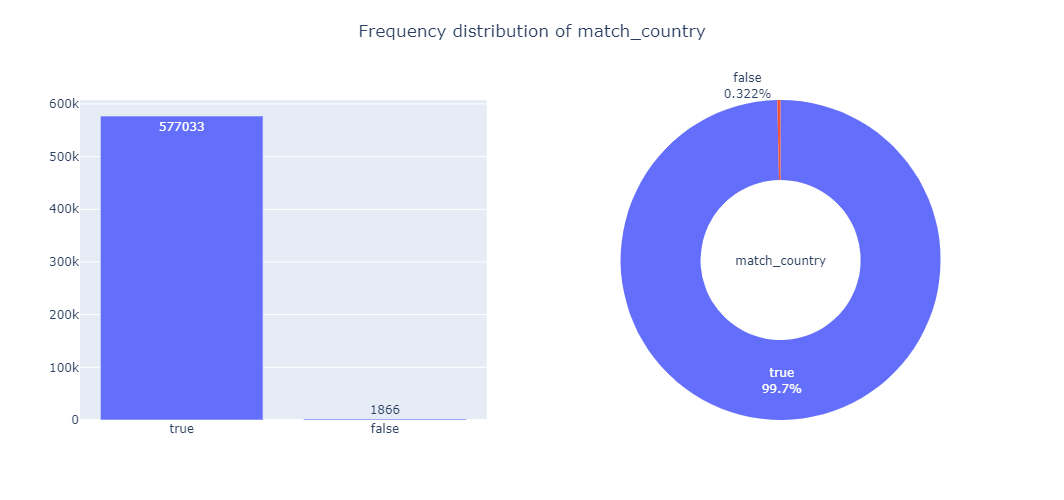

In [83]:
# Barplot and donutplot of 'match_country'
count(data_pairs_feat, 'match_country')

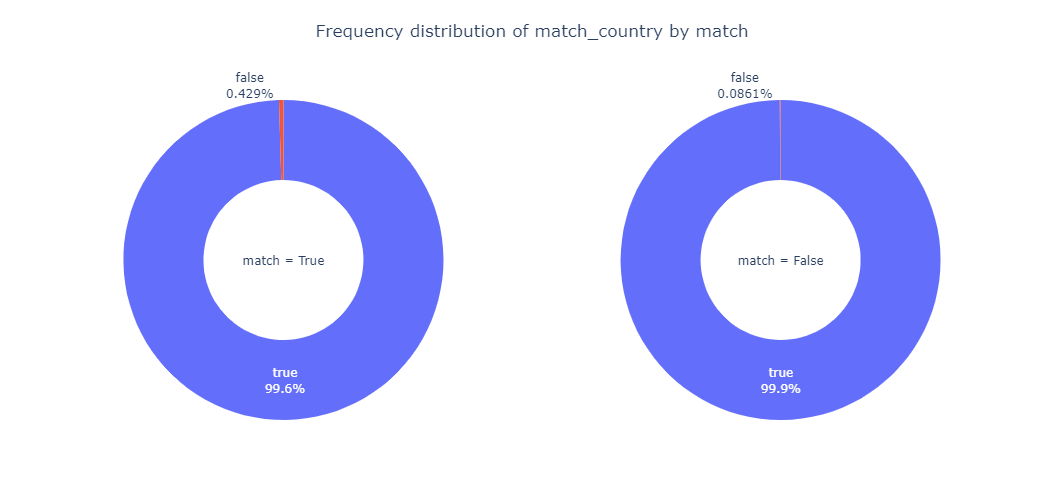

In [84]:
# Donutplots of 'match_country' for different target classes
donut(data_pairs_feat, 'match_country', 'match')

Curiously, the pregenerated set of pairs predominantly $(99.7\%)$ contains pairs of observations from same country. One reason perhaps is that if two observations are reported to be from different countries, then they certainly refer to different POIs (unless something is horrendously wrong). So those pairs can be classified as `match == False` with reasonable confidence from common sense itself, without requiring any classification algorithm. Although there may be errors due to faulty records, as seen by $0.4\%$ observations in the `match == True` class, for which `match_country == False`. Nonetheless, for the modeling purpose, it maybe useful to focus mostly on the pairs that have observations from the same country.

## Matching of States

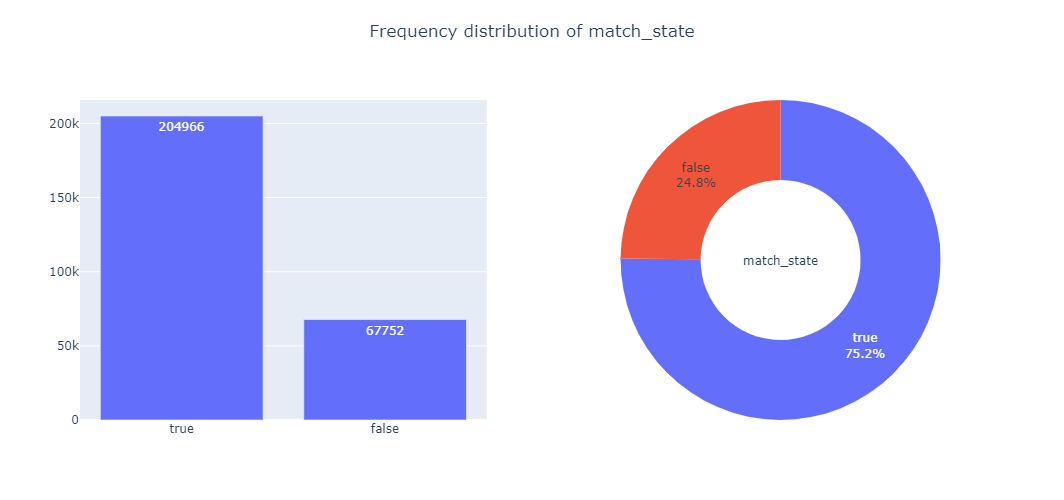

In [85]:
# Barplot and donutplot of 'match_state'
count(data_pairs_feat, 'match_state')

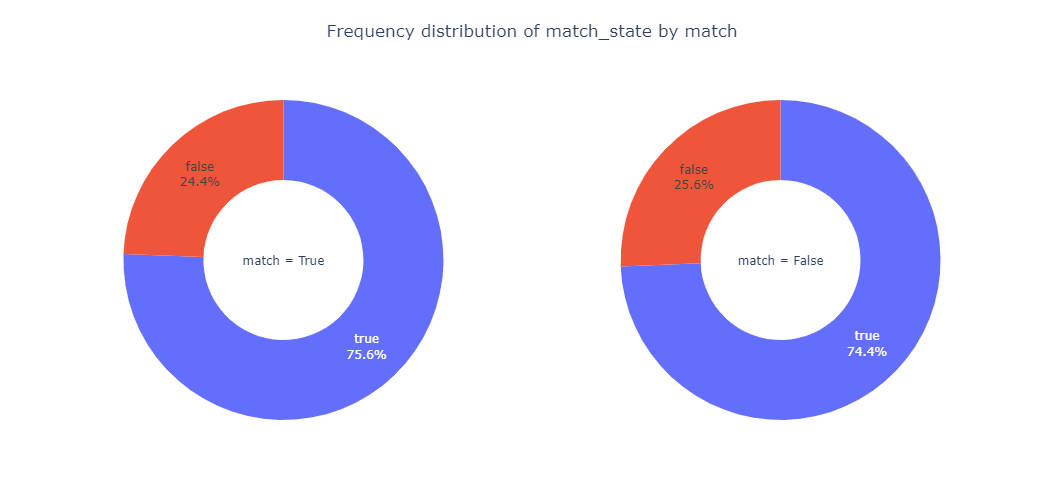

In [86]:
# Donutplots of 'match_state' for different target classes
donut(data_pairs_feat, 'match_state', 'match')

## Matching of Cities

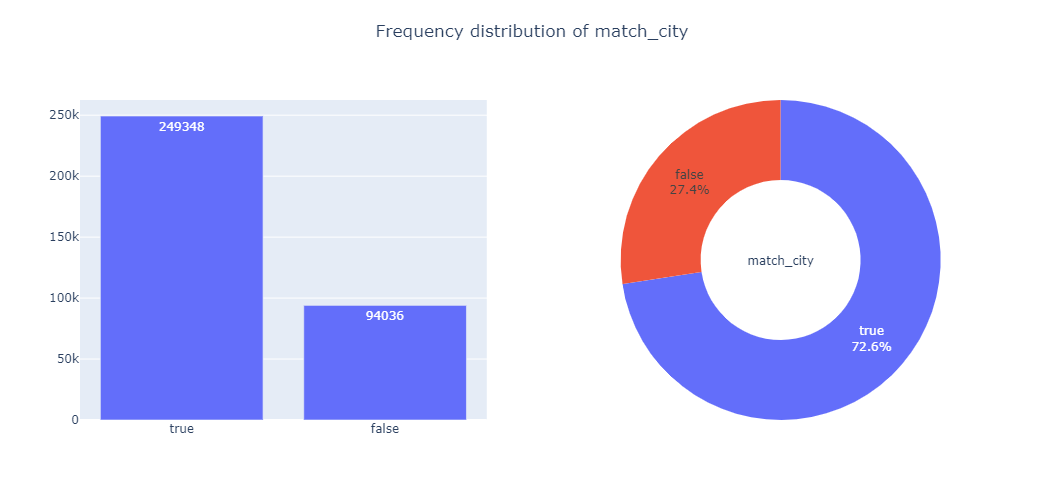

In [87]:
# Barplot and donutplot of 'match_city'
count(data_pairs_feat, 'match_city')

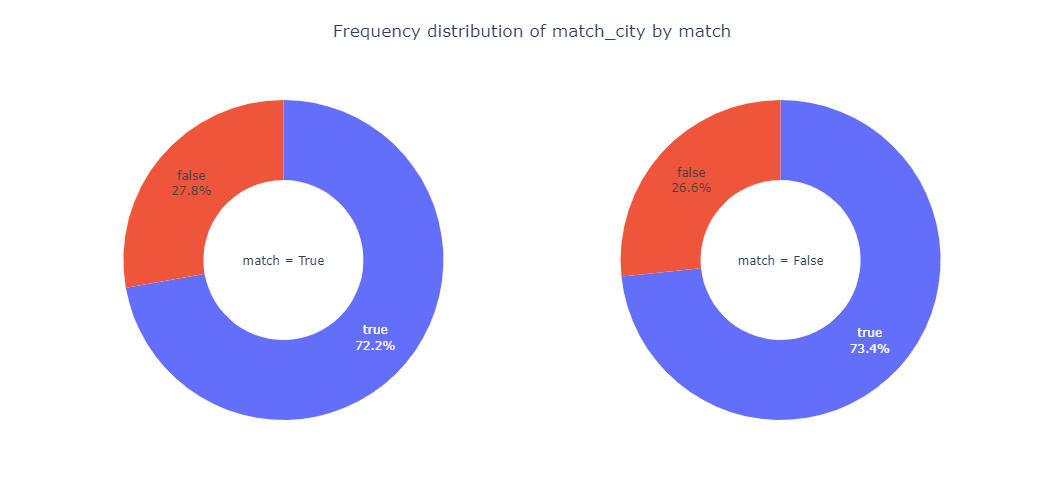

In [88]:
# Donutplots of 'match_city' for different target classes
donut(data_pairs_feat, 'match_city', 'match')

## Matching of ZIP Codes

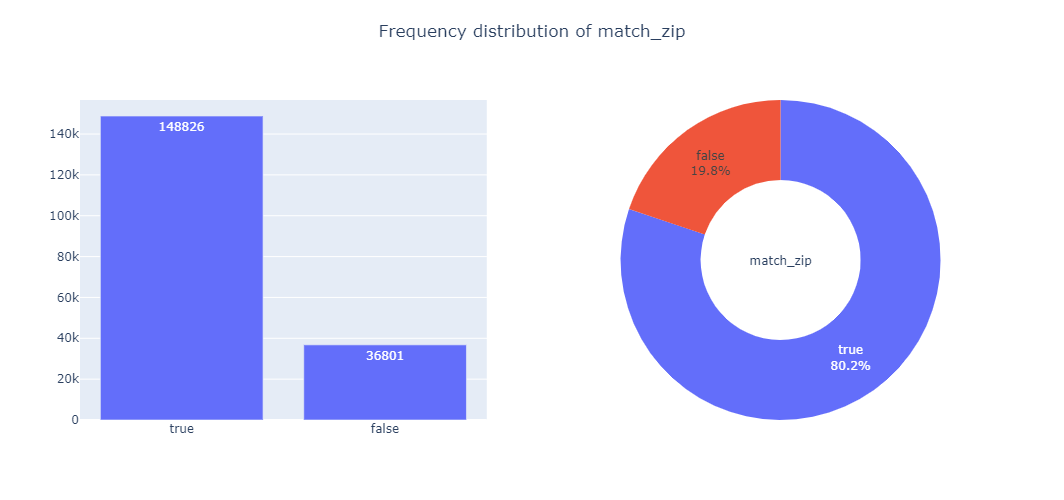

In [89]:
# Barplot and donutplot of 'match_zip'
count(data_pairs_feat, 'match_zip')

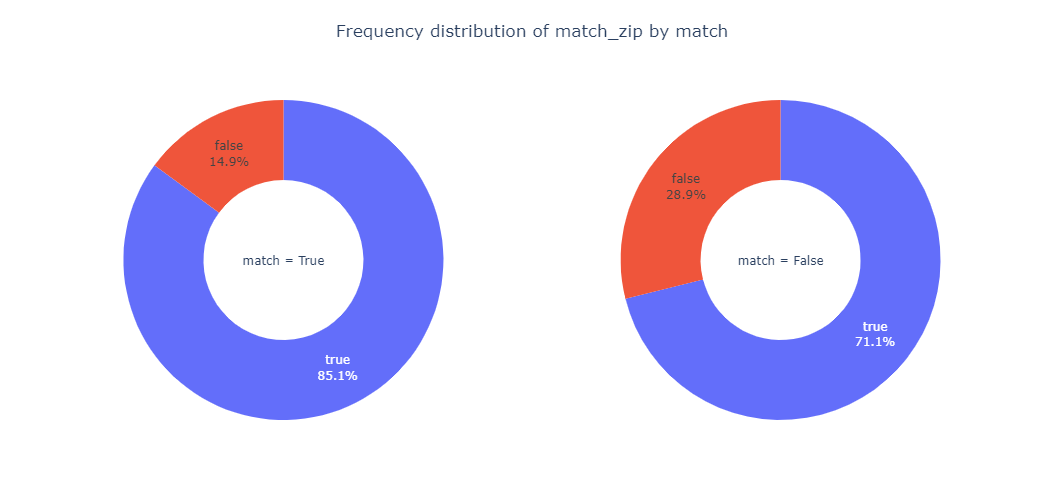

In [90]:
# Donutplots of 'match_zip' for different target classes
donut(data_pairs_feat, 'match_zip', 'match')

## Matching of Categories

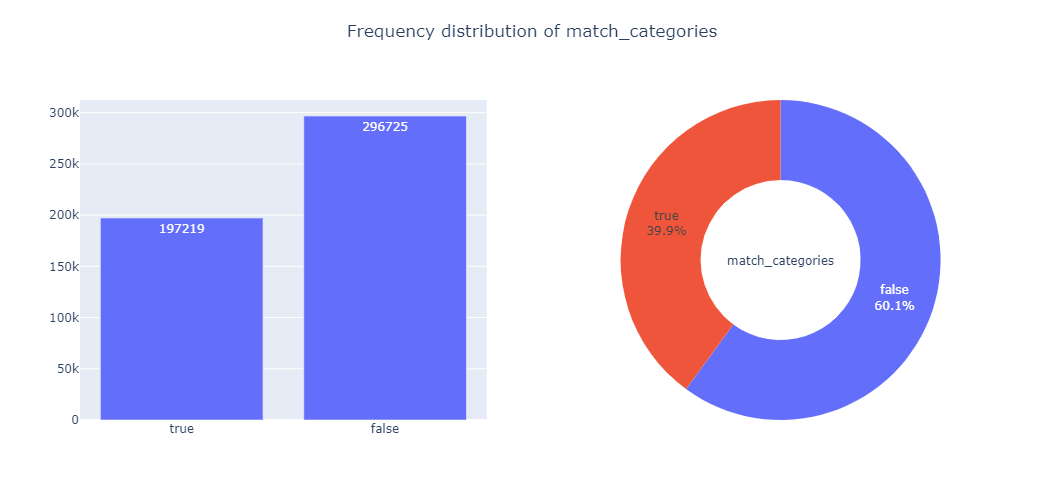

In [91]:
# Barplot and donutplot of 'match_categories'
count(data_pairs_feat, 'match_categories')

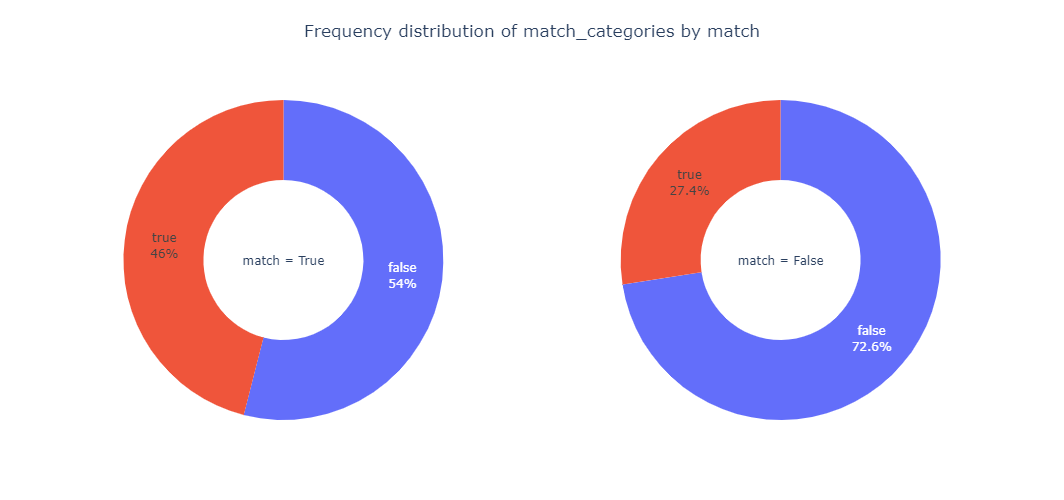

In [92]:
# Donutplots of 'match_categories' for different target classes
donut(data_pairs_feat, 'match_categories', 'match')

Unlike other matching attributes, the `matching_categories` is *false* for majority of the pairs in the pregenerated set, i.e. for majority of pairs, category of the two observations do not match.

# 6. Multivariate Analysis - Pairs Set

- Correlation structure of numerical features
- Bivariate scatterplots of numerical features
- Trivariate scatterplots of numerical features
- Contingency tables of categorical features
- Numerical features for different classes of categorical features

## Correlation structure of numerical features

[Correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) is a statistical measure of linear dependence between two variables. Extreme correlation gives an indication that the two variables are linearly related, however this does not prove any causal relationship between the said variables. The measure is defined as the covariance of the two variables, scaled by the product of respective standard deviations. Let $\left\{\left(x_1, y_1\right), \left(x_2, y_2\right), \cdots, \left(x_n, y_n\right)\right\}$ be paired data on the variables $\left(x, y\right)$. Then the correlation coefficient of the two variables is given by
$$ r_{xy} := \frac{\text{cov}\left(x, y\right)}{s_x s_y} = \frac{\frac{1}{n}\sum_{i=1}^n\left(x_i - \bar{x}\right)\left(y_i - \bar{y}\right)}{\sqrt{\frac{1}{n}\sum_{i=1}^n\left(x_i - \bar{x}\right)^2} \sqrt{\frac{1}{n}\sum_{i=1}^n\left(y_i - \bar{y}\right)^2}},$$

where $\bar{x}$ and $\bar{y}$ denote the respective sample means of the two variables, given by $\bar{x} = \frac{1}{n}\sum_{i=1}^n x_i$ and $\bar{y} = \frac{1}{n}\sum_{i=1}^n y_i$.

In [93]:
# Correlation coefficients of pairs of numerical features
df_corr = pd.DataFrame(columns = ['feature_1', 'feature_2', 'all pairs', 'matched pairs', 'unmatched pairs'])
cols_num = data_pairs_feat.columns[(data_pairs_feat.dtypes == 'int64') | (data_pairs_feat.dtypes == 'float64')].tolist()
data_true = data_pairs_feat[data_pairs_feat['match'] == True]
data_false = data_pairs_feat[data_pairs_feat['match'] == False]
for i in range(len(cols_num)):
    for j in range(len(cols_num)):
        if i < j:
            df_corr.loc[len(df_corr.index)] = [cols_num[i], cols_num[j], data_pairs_feat[cols_num[i]].corr(data_pairs_feat[cols_num[j]]), data_true[cols_num[i]].corr(data_true[cols_num[j]]), data_false[cols_num[i]].corr(data_false[cols_num[j]])]
df_corr.sort_values(by = 'all pairs', ascending = False, inplace = True)
df_corr

feature_1     feature_2  all pairs  matched pairs  unmatched pairs
35      lcss_url    lcss_phone   0.487519       0.468111         0.529025
21      dist_url    dist_phone   0.422392       0.402551         0.462905
34  lcss_address    lcss_phone   0.235011       0.255409         0.193537
16  dist_address    dist_phone   0.228992       0.241187         0.200737
8      dist_name  dist_address   0.153511       0.168742         0.118457
33  lcss_address      lcss_url   0.137199       0.155245         0.102203
30     lcss_name  lcss_address   0.130620       0.184583        -0.000657
15  dist_address      dist_url   0.097019       0.097460         0.096496
10     dist_name    dist_phone   0.091569       0.080214         0.144303
9      dist_name      dist_url   0.079477       0.061126         0.151761
32     lcss_name    lcss_phone   0.073547       0.074755         0.122646
31     lcss_name      lcss_url   0.066525       0.051111         0.162740
3       dist_loc    dist_phone   0.014091       0.011410         0.017970
2       dist_loc      dist_url   0.011872       0.009839         0.012891
0       dist_loc     dist_name   0.002812       0.002250         0.012987
1       dist_loc  dist_address   0.002366      -0.001525         0.016115
4       dist_loc     lcss_name   0.000717      -0.001537        -0.012597
5       dist_loc  lcss_address  -0.003563       0.000548        -0.020733
22      dist_url     lcss_name  -0.009475       0.004620        -0.105157
6       dist_loc      lcss_url  -0.014798      -0.014373        -0.010849
7       dist_loc    lcss_phone  -0.016941      -0.015205        -0.018912
26    dist_phone     lcss_name  -0.052636      -0.056309        -0.106555
23      dist_url  lcss_address  -0.069847      -0.068816        -0.080614
17  dist_address     lcss_name  -0.101877      -0.122863        -0.064216
14     dist_name    lcss_phone  -0.113880      -0.101603        -0.163916
13     dist_name      lcss_url  -0.126255      -0.112620        -0.183195
12     dist_name  lcss_address  -0.140106      -0.178159        -0.041992
19  dist_address      lcss_url  -0.146973      -0.159023        -0.118690
27    dist_phone  lcss_address  -0.218265      -0.233119        -0.191767
20  dist_address    lcss_phone  -0.237262      -0.252801        -0.200609
25      dist_url    lcss_phone  -0.414829      -0.395599        -0.455682
28    dist_phone      lcss_url  -0.479988      -0.460242        -0.520994
11     dist_name     lcss_name  -0.511000      -0.502332        -0.520482
18  dist_address  lcss_address  -0.518955      -0.502117        -0.558679
24      dist_url      lcss_url  -0.648429      -0.636023        -0.674016
29    dist_phone    lcss_phone  -0.974977      -0.974243        -0.976966

The correlation structure of the numerical features are more or less similar for pairs with `match == True` and pairs with `match == False`.

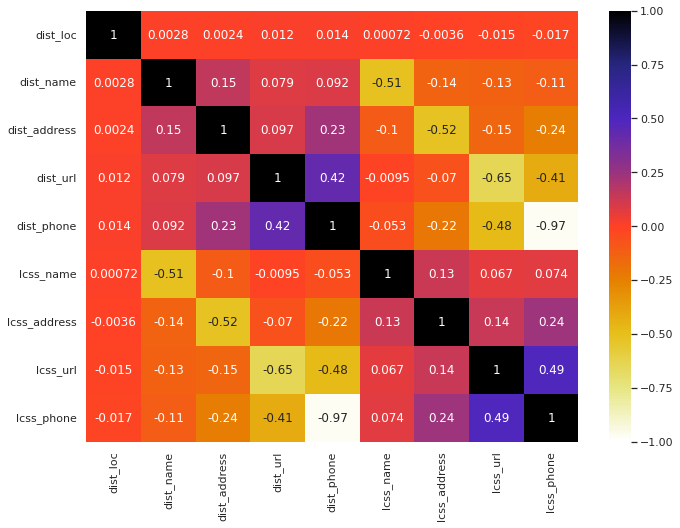

In [94]:
# Correlation heatmap of numerical features
plt.figure(figsize = (10, 7.5))
sns.heatmap(data_pairs_feat[cols_num].corr(), vmin = -1, vmax = 1, annot = True, cmap = plt.cm.CMRmap_r)
plt.tight_layout()
plt.show()

- `dist_loc` is approximately uncorrelated with each of the other numerical features
- `dist_address` has slight positive correlation with `dist_name` and `dist_phone`
- `dist_url` and `dist_phone` have moderate positive correlation
- `dist_x` and `lcss_x` has high negative correlation for x = `name`, `address`, `url` and `phone`, which is expected as `dist_x` is a distance measure and `lcss_x` is a similarity measure, and hence the two are antithesis of each other

## Bivariate scatterplots of numerical features

In [95]:
# Numerical columns except lcss features
cols_dist = ['dist_loc', 'dist_name', 'dist_address', 'dist_url', 'dist_phone']

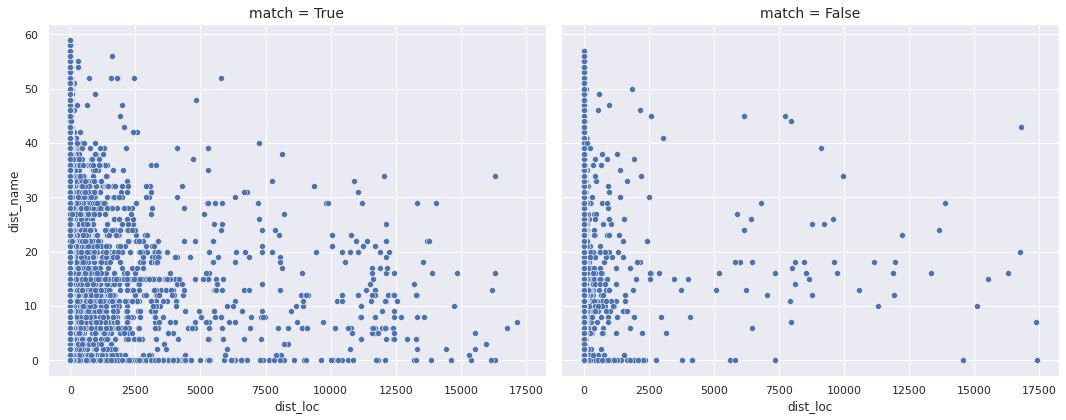

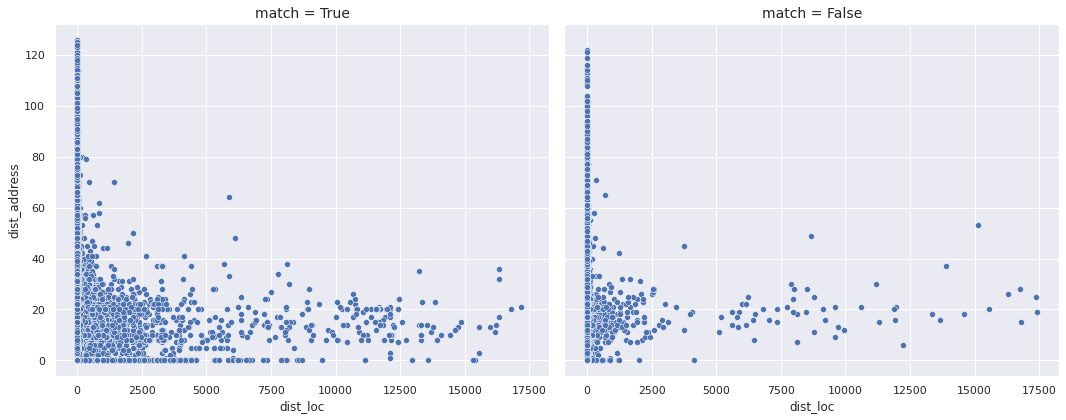

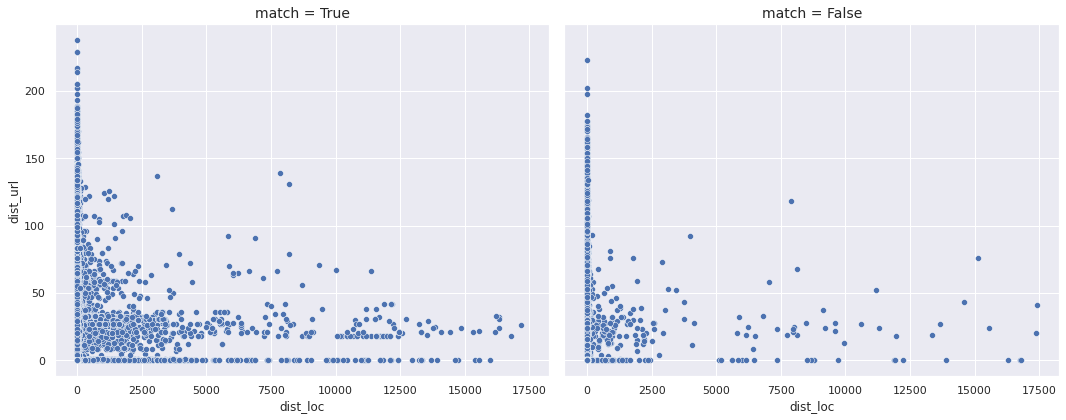

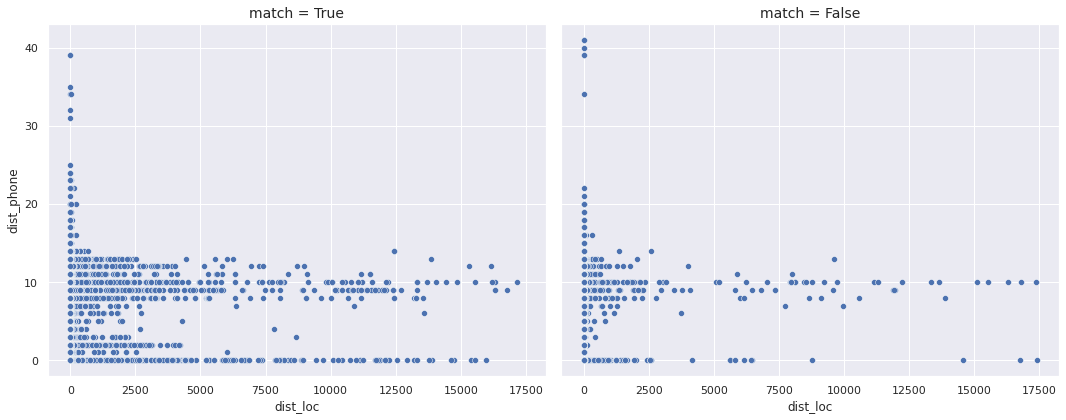

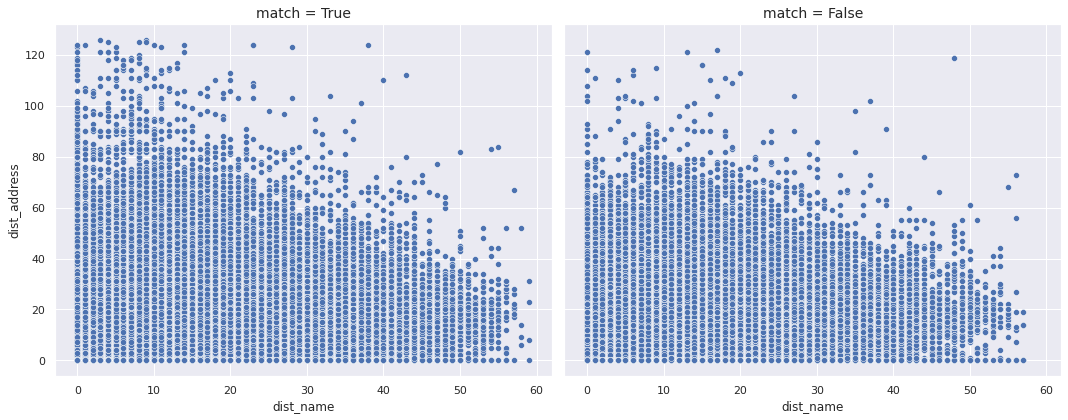

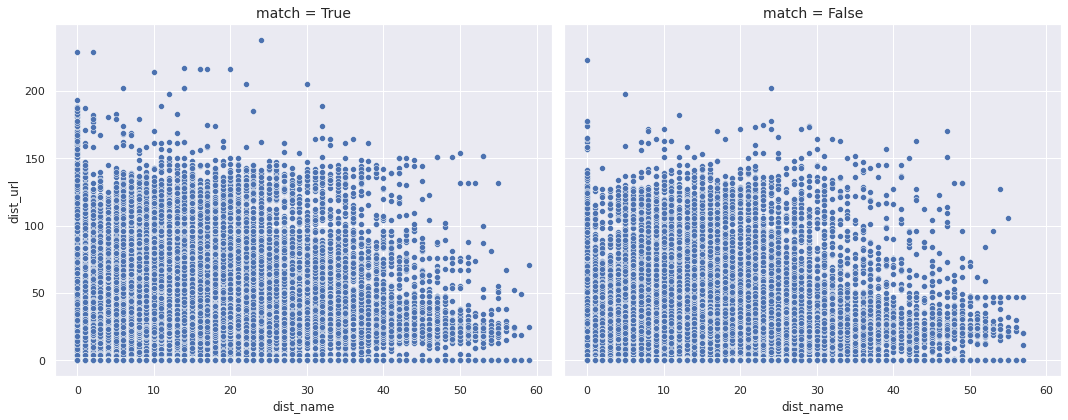

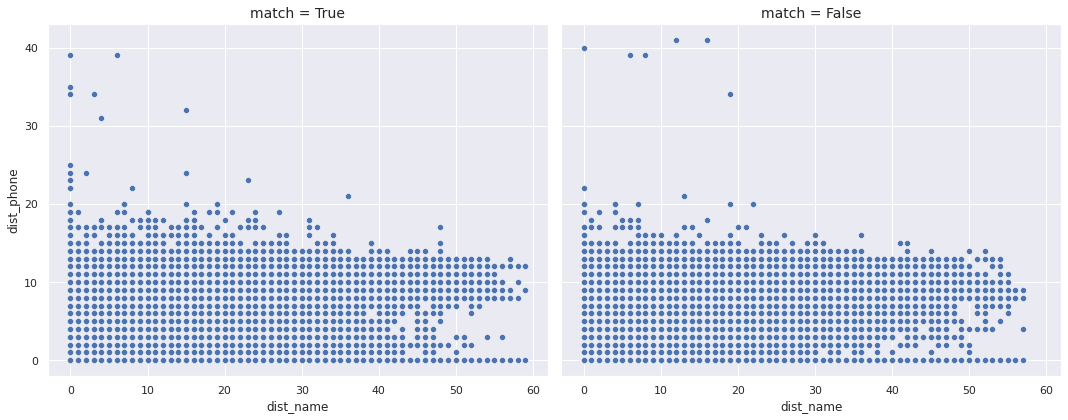

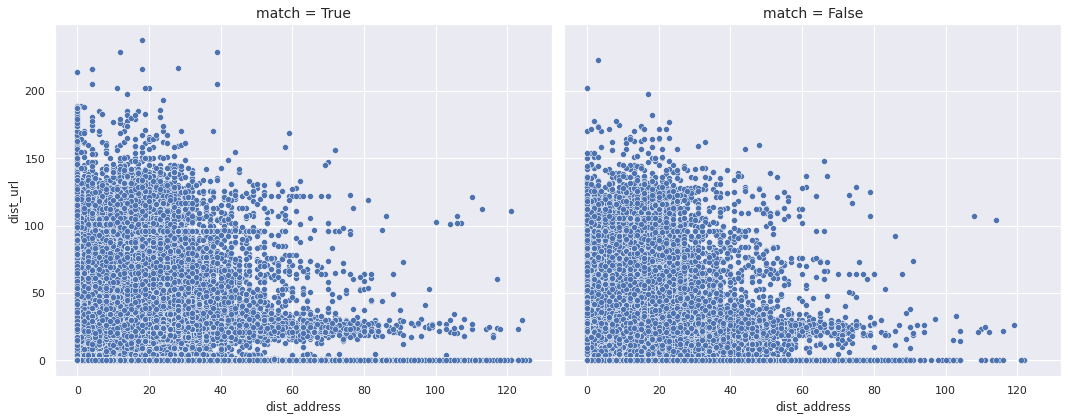

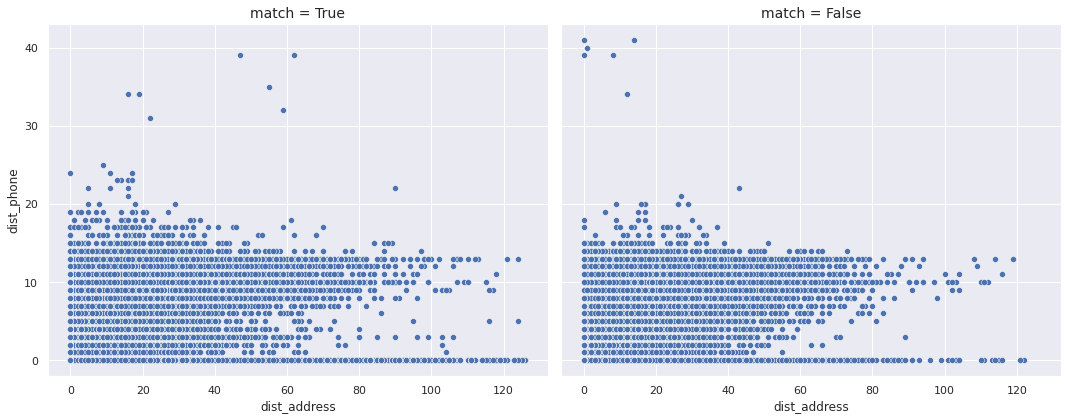

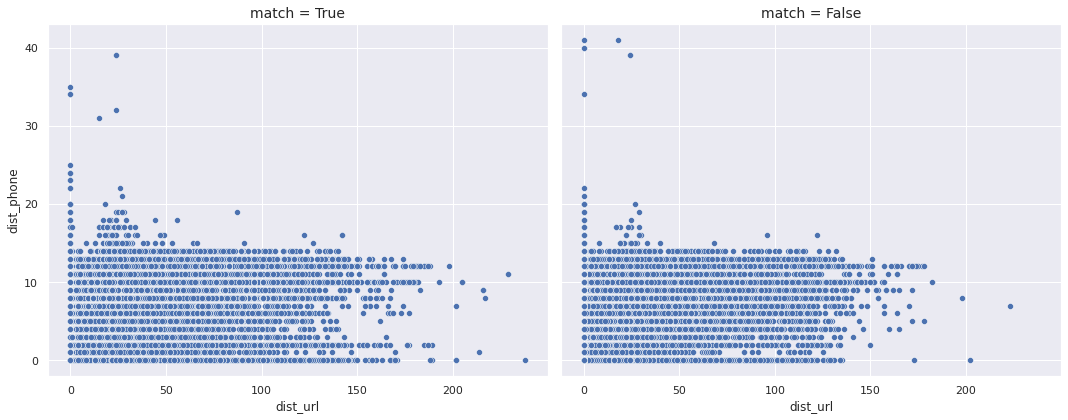

In [96]:
# Bivariate scatterplots of numerical columns except lcss features
pairs = [(cols_dist[i], cols_dist[j]) for i in range(len(cols_dist)) for j in range(len(cols_dist)) if i < j]
for z in pairs:
    fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharex = True, sharey = True)
    sns.scatterplot(data = data_pairs_feat[data_pairs_feat['match'] == True], x = z[0], y = z[1], ax = ax[0])
    ax[0].set_title("match = True", fontsize = 14)
    sns.scatterplot(data = data_pairs_feat[data_pairs_feat['match'] == False], x = z[0], y = z[1], ax = ax[1])
    ax[1].set_title("match = False", fontsize = 14)
    plt.tight_layout()
plt.show()

## Trivariate scatterplots of numerical features

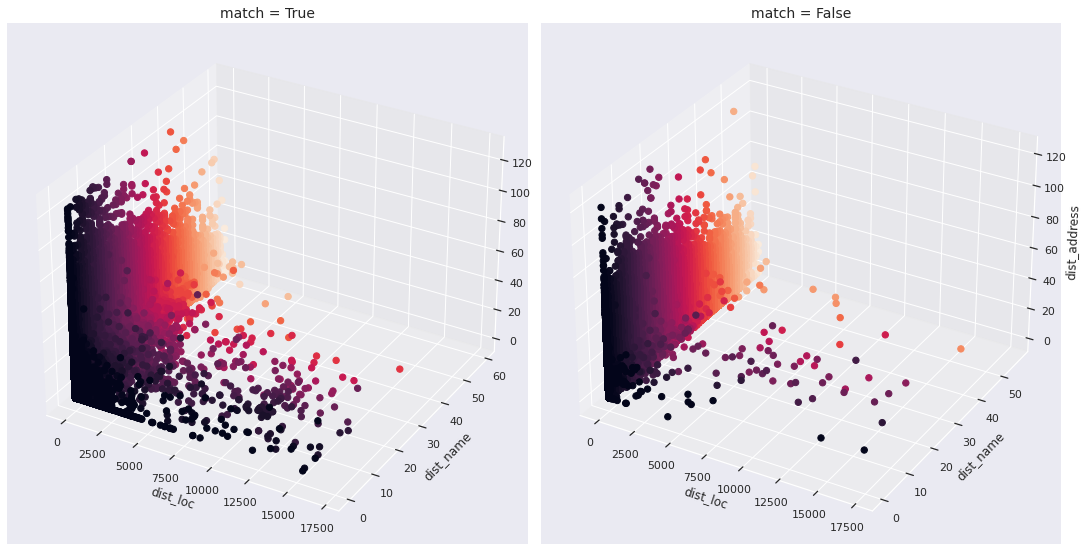

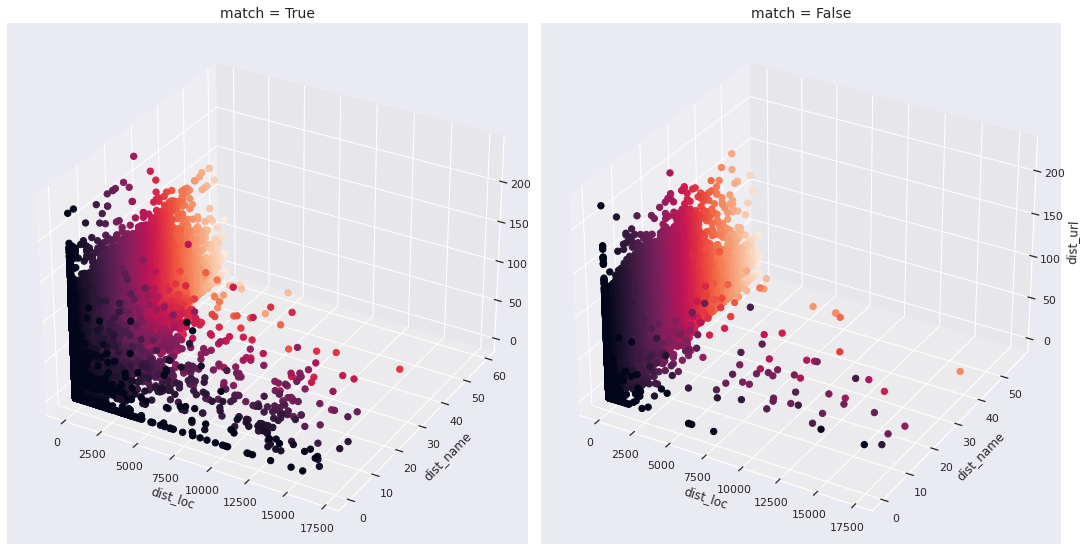

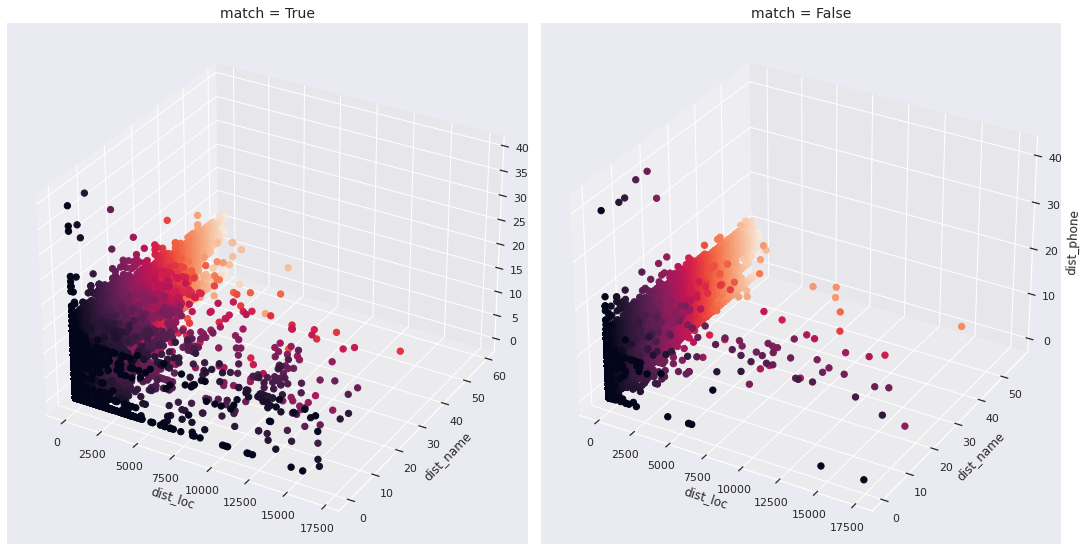

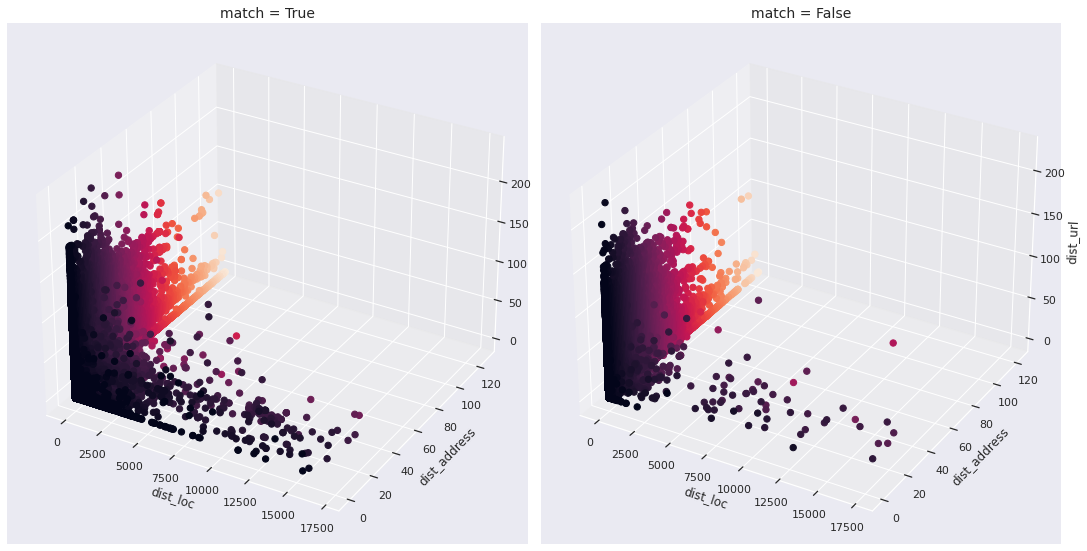

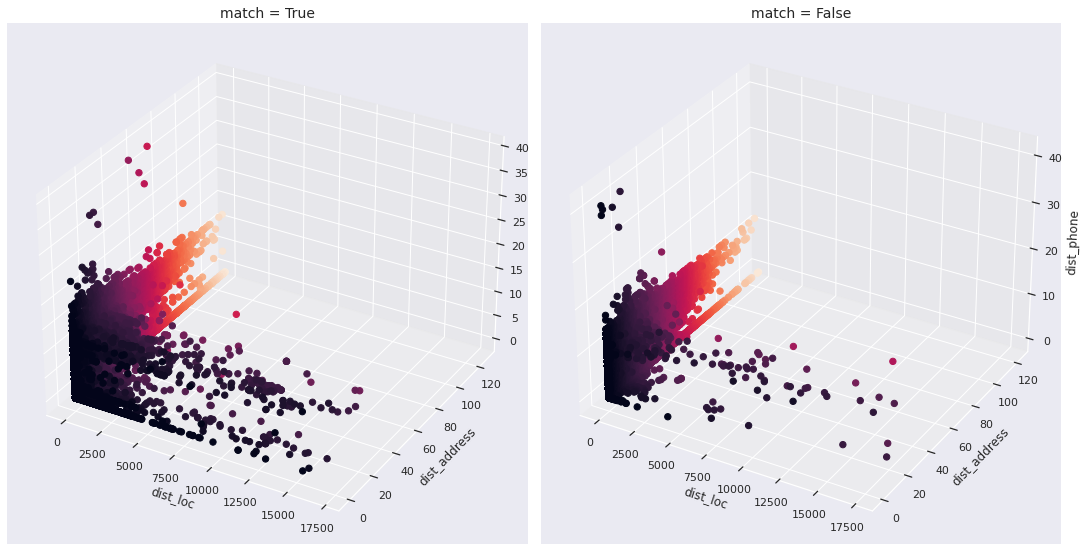

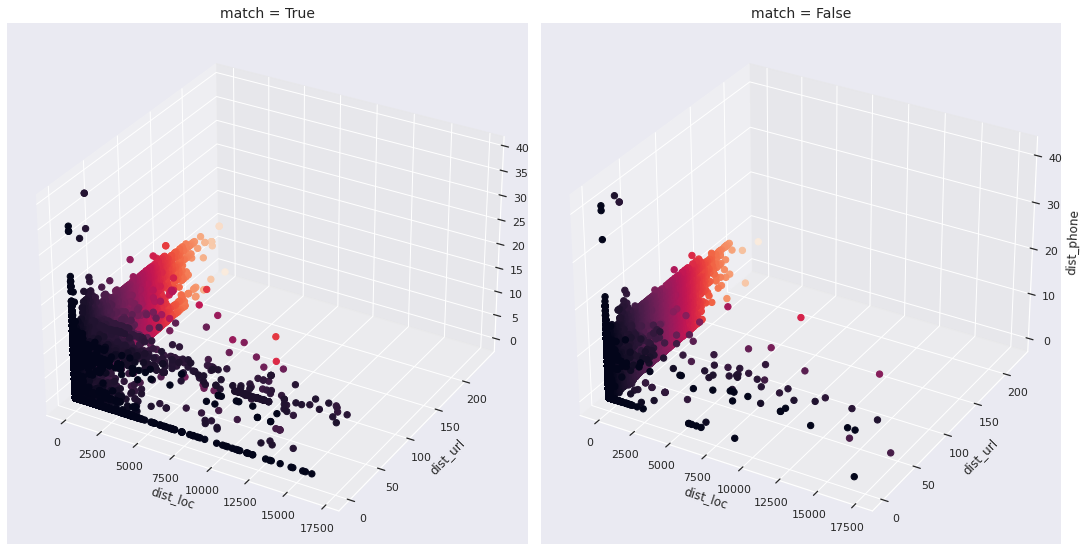

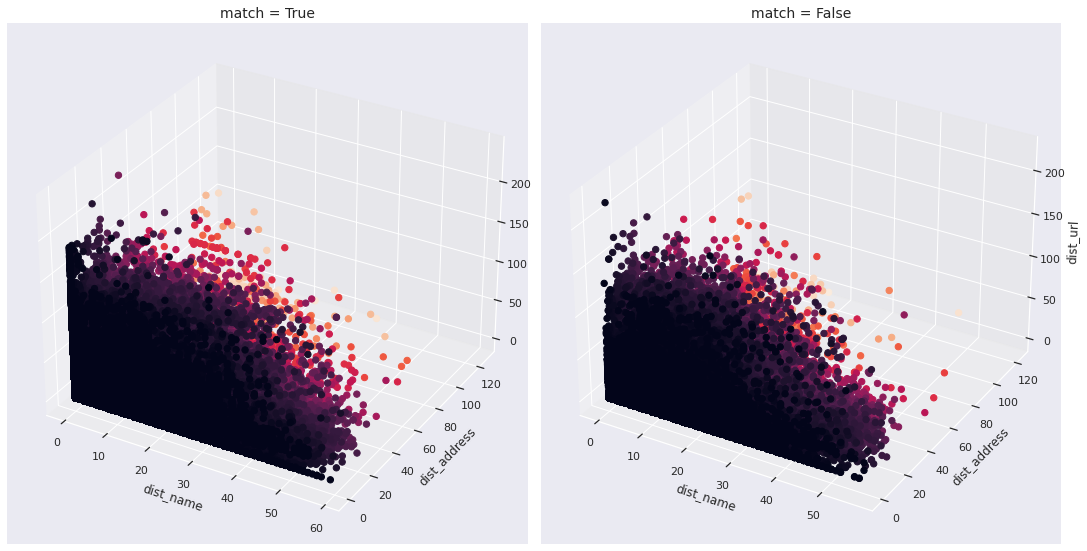

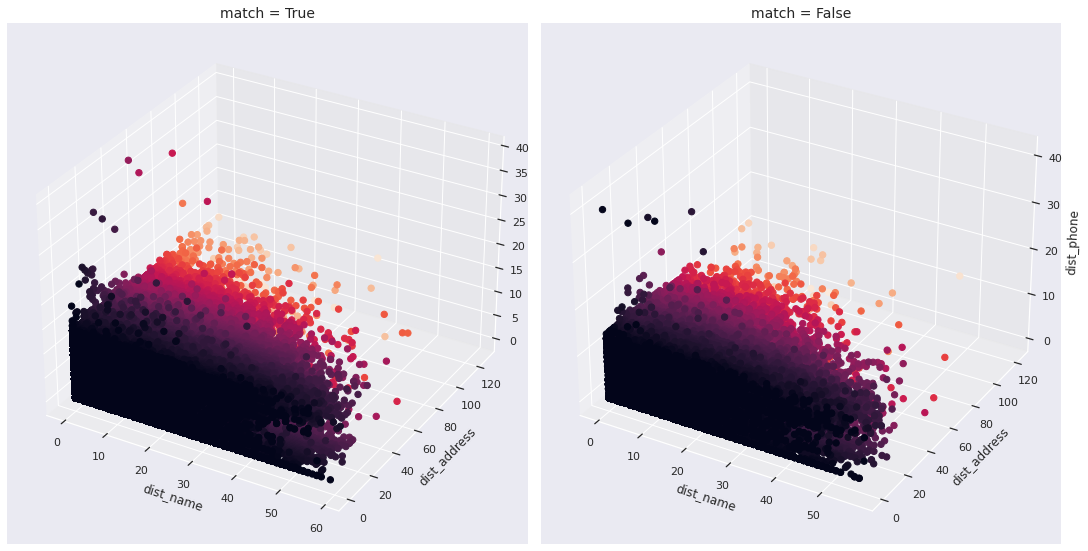

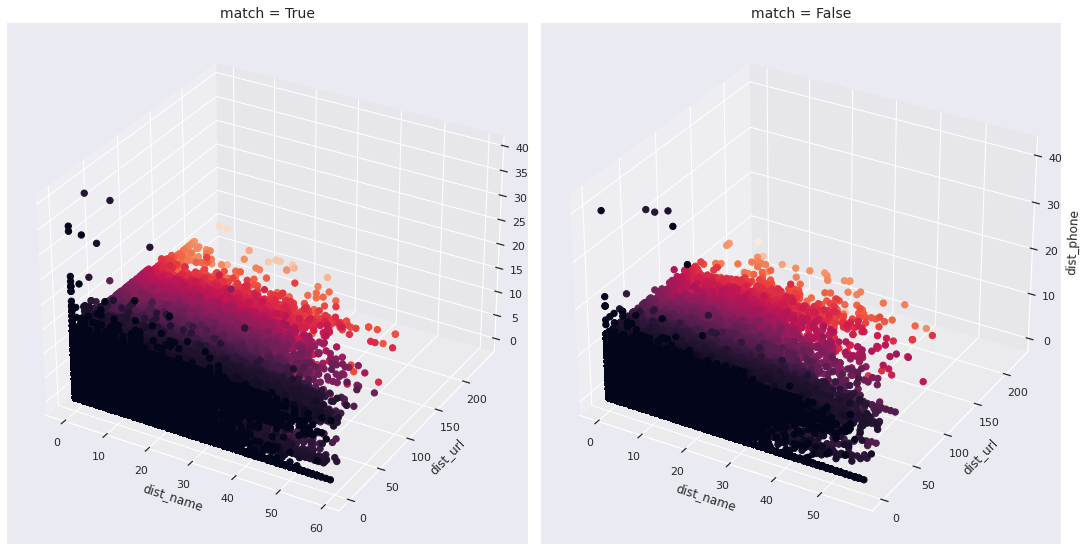

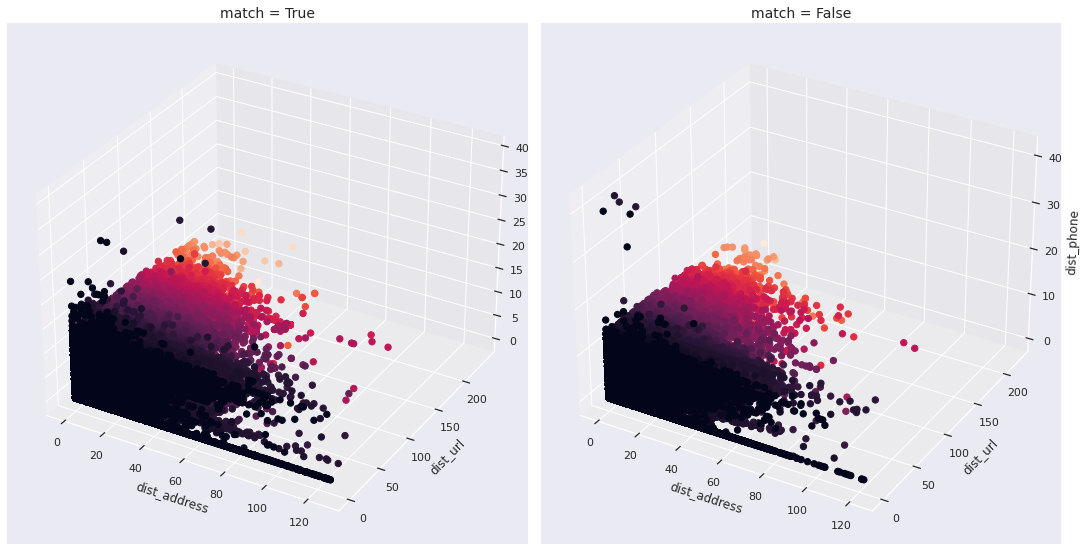

In [97]:
# Trivariate scatterplots of numerical features except lcss features
triples = [(cols_dist[i], cols_dist[j], cols_dist[k]) for i in range(len(cols_dist)) for j in range(len(cols_dist)) for k in range(len(cols_dist)) if i < j < k]
for z in triples:
    fig = plt.figure(figsize = (15, 9))
    ax = fig.add_subplot(1, 2, 1, projection = '3d')
    x_true = data_pairs_feat[data_pairs_feat['match'] == True][z[0]]
    y_true = data_pairs_feat[data_pairs_feat['match'] == True][z[1]]
    z_true = data_pairs_feat[data_pairs_feat['match'] == True][z[2]]
    s1 = ax.scatter(x_true, y_true, z_true, s = 40, marker = 'o', c = y_true, alpha = 1)
    ax.set_title("match = True", fontsize = 14)
    ax.set_xlabel(z[0])
    ax.set_ylabel(z[1]) # ax.set_zlabel(z[2])
    ax = fig.add_subplot(1, 2, 2, projection = '3d')
    x_false = data_pairs_feat[data_pairs_feat['match'] == False][z[0]]
    y_false = data_pairs_feat[data_pairs_feat['match'] == False][z[1]]
    z_false = data_pairs_feat[data_pairs_feat['match'] == False][z[2]]
    s2 = ax.scatter(x_false, y_false, z_false, s = 40, marker = 'o', c = y_false, alpha = 1)
    ax.set_title("match = False", fontsize = 14)
    ax.set_xlabel(z[0])
    ax.set_ylabel(z[1])
    ax.set_zlabel(z[2])
    plt.tight_layout()
plt.show()

## Contingency tables of categorical features

In [98]:
# Function to compute contingency tables for pairs of binary features
def contingency_pairs(df, pairs, ncols = 3, figsize_multiplier = 4, update_ylabel = False):
    """
    Prints contingency tables for selected pairs of binary features
    Args:
      df (DataFrame):             dataframe having binary columns which appear in any pair in the input list pairs
      pairs (list):               list of pairs of binary columns of df
      ncols (int):                number of columns of the grid of contingency tables
      figsize_multiplier (float): a multiplicative factor that determines the size of the output figure
      update_ylabel (Boolean):    if true, removes the ylabels of the tables not in the first column of the grid
    
    Returns:
      Nothing, prints contingency tables for pairs of binary features in the list pairs, in grid form with ncols columns
    """
    nrows = math.ceil(len(pairs) / ncols)
    figsize = (figsize_multiplier * ncols, 0.8 * figsize_multiplier * nrows)
    fig, ax = plt.subplots(nrows, ncols, figsize = figsize, sharey = False)
    labels = [True, False]
    for i in range(len(pairs)):
        contingency_mat = np.zeros(shape = (2, 2))
        for j in range(2):
            for k in range(2):
                contingency_mat[j][k] = len([l for l in range(len(df)) if df[pairs[i][0]][l] == labels[j] and df[pairs[i][1]][l] == labels[k]])
        contingency_df = pd.DataFrame(contingency_mat)
        hm = sns.heatmap(contingency_df, annot = True, annot_kws = {"size": 16}, fmt = 'g', ax = ax[i // ncols, i % ncols])
        hm.set_xlabel(f'{pairs[i][1]}', fontsize = 14)
        hm.set_ylabel(f'{pairs[i][0]}', fontsize = 14)
        hm.set_xticklabels(labels, fontdict = {'fontsize': 12}, rotation = 0, ha = "right")
        hm.set_yticklabels(labels, fontdict = {'fontsize': 12}, rotation = 0, ha = "right")
        if i % ncols != 0 and update_ylabel == True:
                ax[i // ncols, i % ncols].set_ylabel(" ")
    plt.tight_layout()
    plt.show()

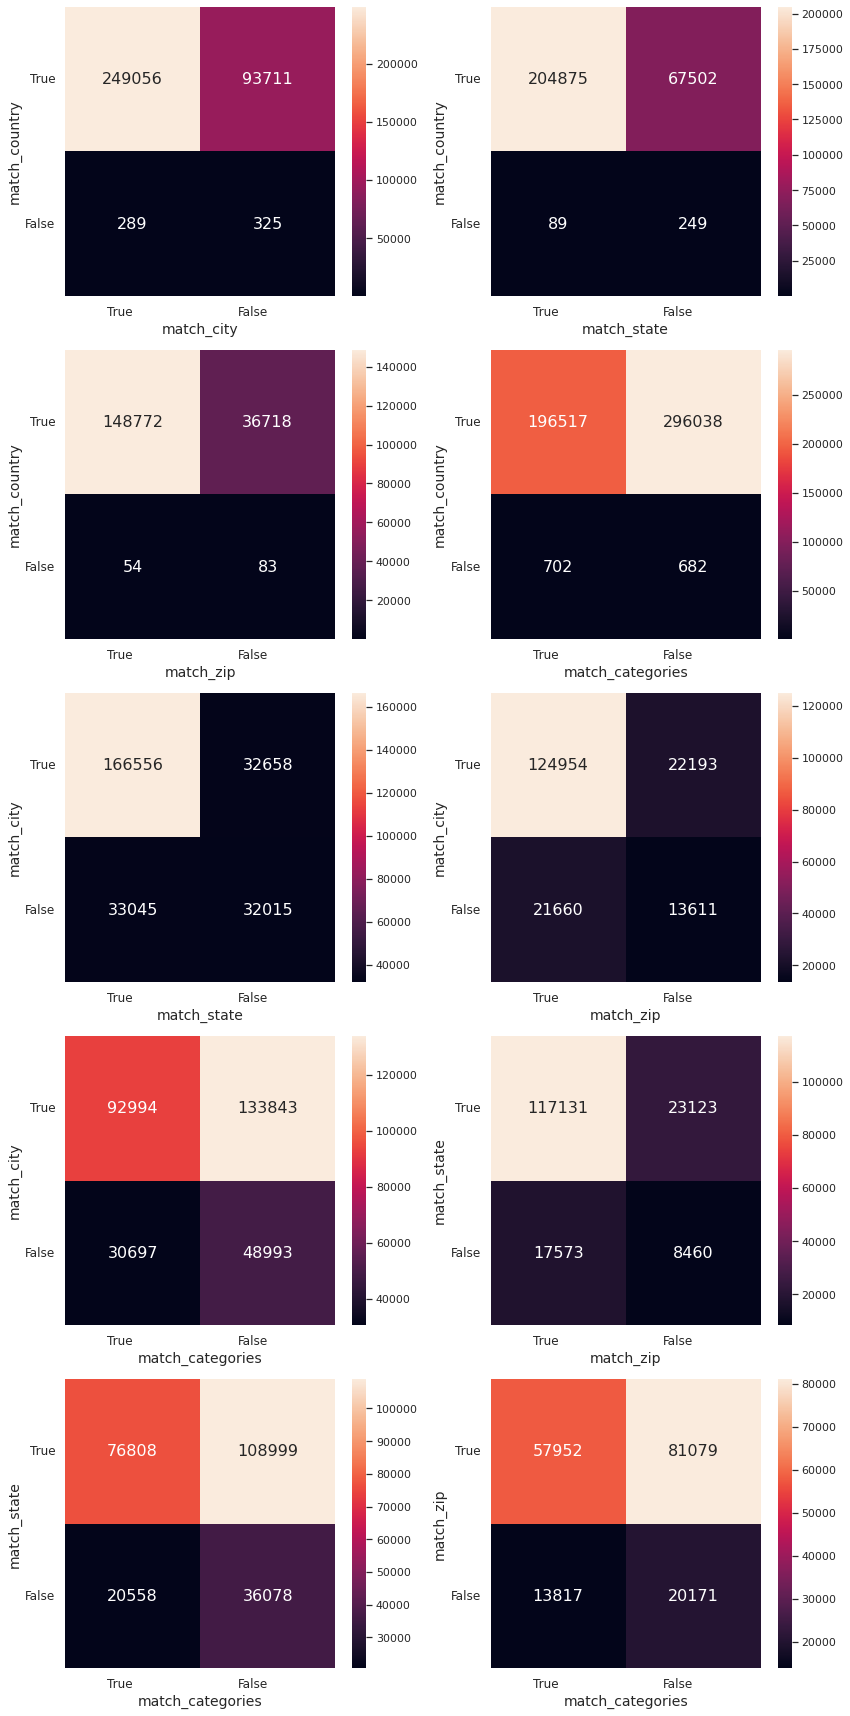

In [99]:
# Contingency tables for pairs of binary features
cols_cat = [col for col in data_pairs_feat.columns if data_pairs_feat[col].nunique() == 2 and col != 'match']
pairs = [(cols_cat[i], cols_cat[j]) for i in range(len(cols_cat)) for j in range(len(cols_cat)) if i < j]
contingency_pairs(data_pairs_feat, pairs, ncols = 2, figsize_multiplier = 6)

## Numerical features for different classes of categorical features

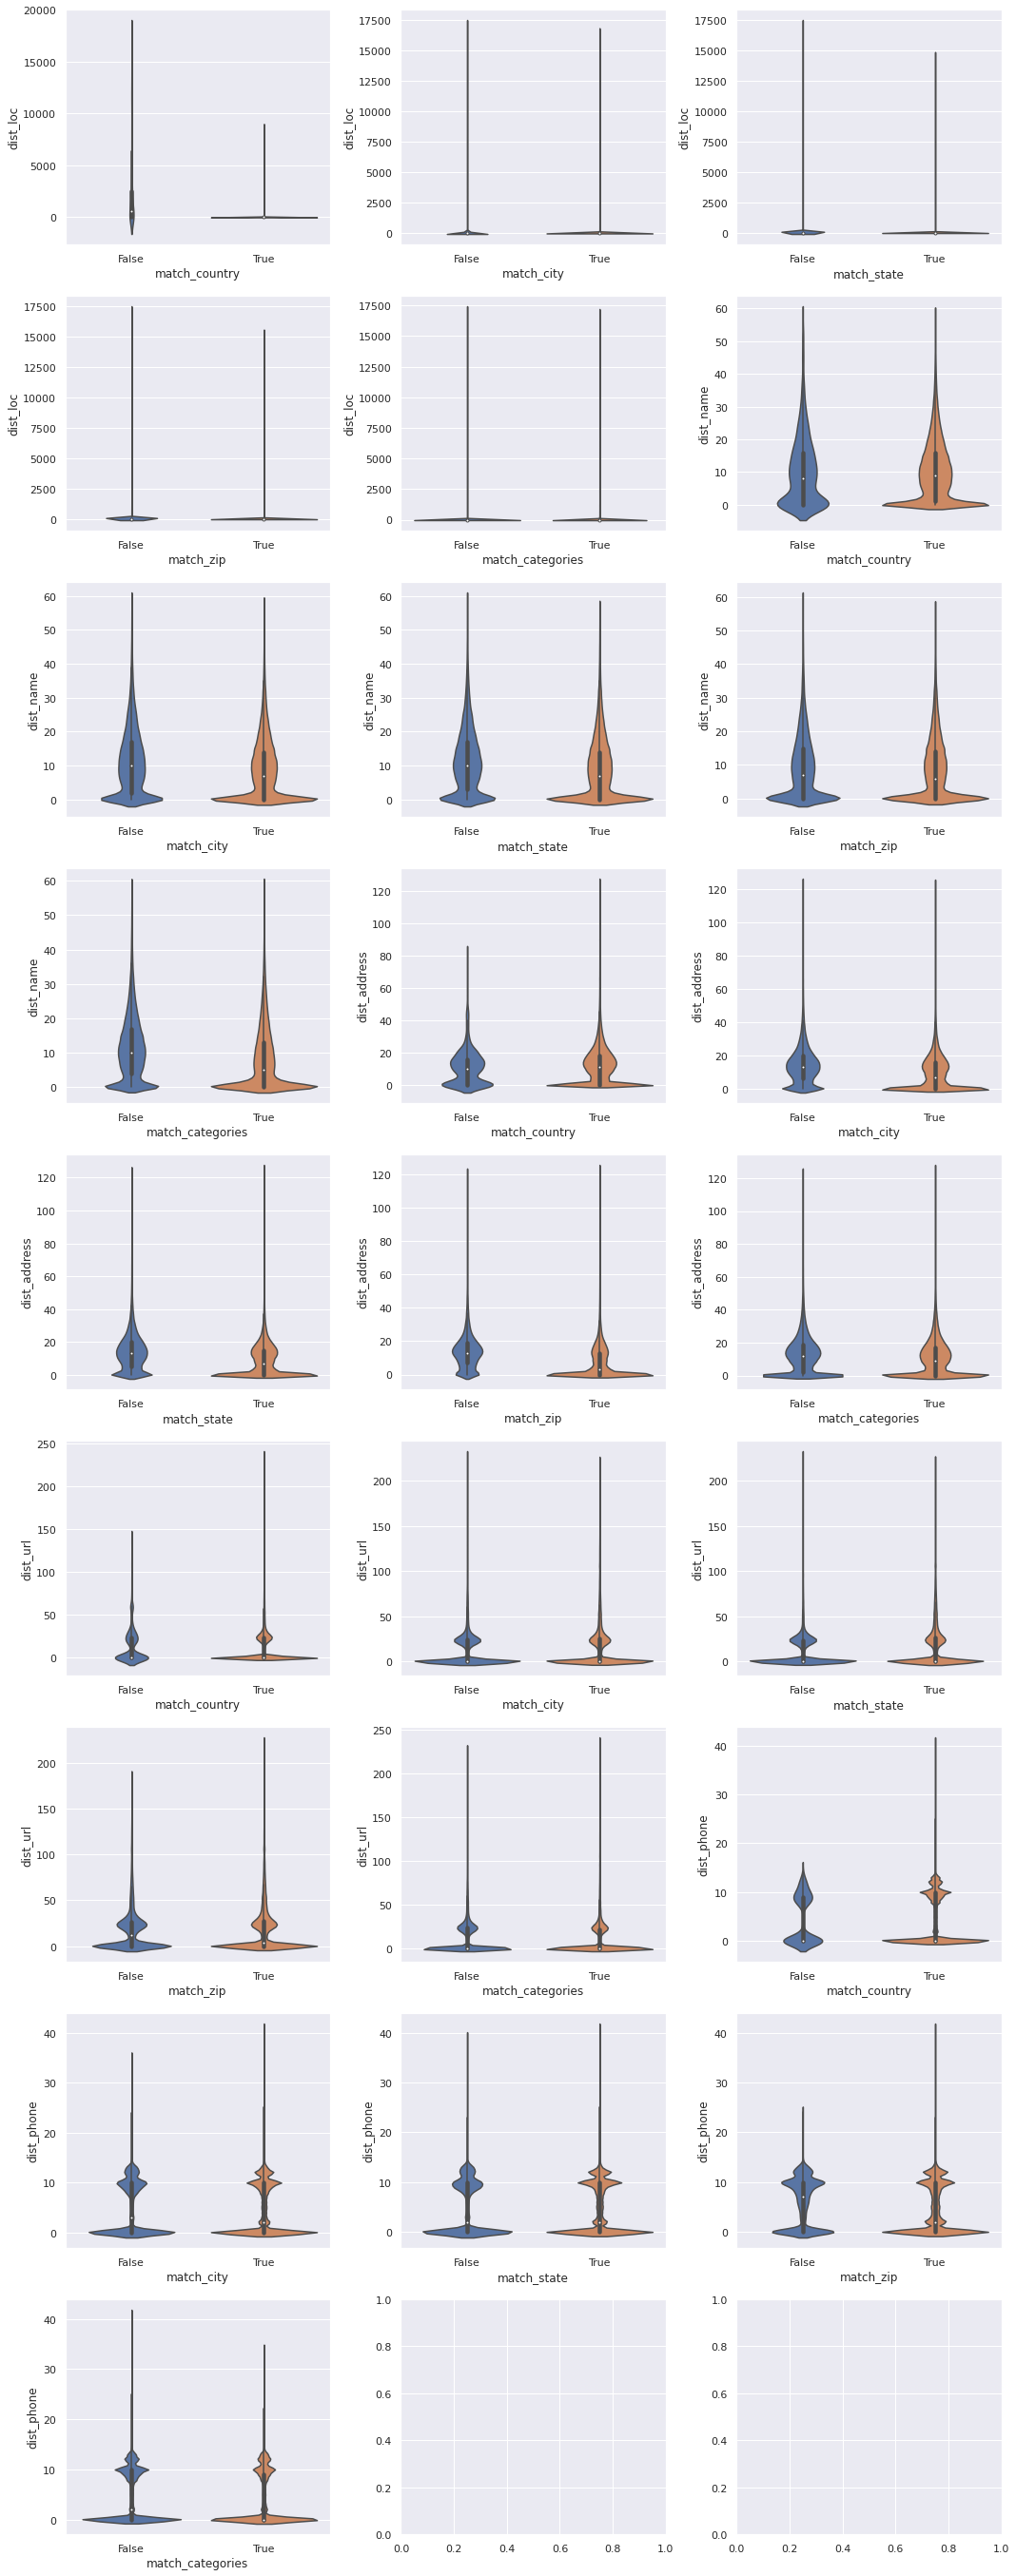

In [100]:
# Numerical features (except lcss features) for different classes of categorical features
pairs = [(cols_dist[i], cols_cat[j]) for i in range(len(cols_dist)) for j in range(len(cols_cat))]
ncols = 3
nrows = math.ceil(len(pairs) / ncols)
fig, ax = plt.subplots(nrows, ncols, figsize = (5 * ncols, 4.2 * nrows), sharey = False)
for i in range(len(pairs)):
    sns.violinplot(data = data_pairs_feat, x = pairs[i][1], y = pairs[i][0], ax = ax[i // ncols, i % ncols])
plt.tight_layout()
plt.show()

Expectedly, all the plots show global peak at $0$ and a local peak not far from it. This observation is consistent with the histograms of the numerical features in the univariate analysis. However, there are some finer details to check in the violinplots for the following features:
- `dist_loc` for different classes of `match_country`, `match_state`, `match_city`, `match_zip`: There is a general dependence between the two features as `dist_loc` should be less in the situations where `match_country == True` than the situations where `match_country == False`. However, this does not hold in general as it is always possible that two POIs are located at the extremely opposite regions on the same country, and also that two POIs are located at nearby regions of two neighbor countries. Similar pattern is reflected in the violinplots of `dist_loc` for different classes of `match_state`, `match_city` and `match_zip`. Interestingly, the pattern does not replicate for `dist_loc` and `match_categories`.
- `dist_name` for different classes of `match_country`, `match_state`, `match_city`, `match_zip`, `match_categories`: Though not as extreme as the cases with `dist_loc`, we observe that `dist_name` is more likely to be $0$ in the situations where the attributes `match_country`, `match_state`, `match_city`, `match_zip`, `match_categories` are *true*, than the situations where the same are *false*.
- `dist_url` and `match_country`: The violinplot for `dist_url` is far less concentrated around $0$ if `match_country == False`, than `match_country == True`. However, the same pattern cannot be seen when `dist_url` is plotted against `match_state`, `match_city` or `match_zip`.
- `dist_phone` and `match_country`: The distributions of `dist_phone` for `match_country == True` and `match_country == False` show considerable difference in concentration about $0$ and presence of outliers, however the distribution of `dist_phone` seems to be more or less unaffected by the status of `match_state`, `match_city`, `match_zip` and `match_categories`.

# Acknowledgements

- [Foursquare - Location Matching](https://www.kaggle.com/competitions/foursquare-location-matching) competition

# References

- [Correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
- [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance)
- [Foursquare City Guide](https://en.wikipedia.org/wiki/Foursquare_City_Guide)
- [Foursquare Labs Inc.](https://foursquare.com/)
- [Foursquare Swarm](https://en.wikipedia.org/wiki/Foursquare_Swarm)
- [Great-circle distance](https://en.wikipedia.org/wiki/Great-circle_distance)
- [Grove Karl Gilbert](https://en.wikipedia.org/wiki/Grove_Karl_Gilbert)
- [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula)
- [ISO 3166-1 alpha-2](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2)
- [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index)
- [Jaccard/Tanimoto similarity test and estimation methods for biological presence-absence data](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3118-5)
- [Jaccard/Tanimoto similarity test and estimation methods (arxiv version)](https://arxiv.org/abs/1903.11372)
- [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance)
- [List of U.S. state and territory abbreviations](https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations)
- [Olympus Mons](https://en.wikipedia.org/wiki/Olympus_Mons)
- [Paul Jaccard](https://en.wikipedia.org/wiki/Paul_Jaccard)
- [Point of interest](https://en.wikipedia.org/wiki/Point_of_interest)
- [Vladimir Levenshtein](https://en.wikipedia.org/wiki/Vladimir_Levenshtein)

In [101]:
# Runtime and memory usage
stop = time.time()
print(pd.Series({"Process runtime": "{:.2f} seconds".format(float(stop - start)),
                 "Process memory usage": "{:.2f} MB".format(float(process.memory_info()[0]/(1024*1024)))}).to_string())

Process runtime         1399.85 seconds
Process memory usage         2504.78 MB
